# CosmoDC

### Goals
- How to interface QP and sacc
- How to create n(z) uncertainties from an ensemble of n(z)'s

### Requirements
- **A sacc file**: we will use the sacc file of Prat et al 2022 (2212.09345). This sacc file contains the summary statistics measured from the CosmoDC2 simulations using the DESC TXPipe pipeline. The summary statistics include the angular power spectra of the shear-shear, position-shear, and position-position correlations, as well as the cross-correlations between the different probes. The sacc file also contains the redshift distributions of the galaxies in the simulations. For more details see Prat et al 2022. The data can found in NERSC at '/global/cfs/cdirs/lsst/groups/WL/projects/star-challenge/gaussian/data_vectors'.

- **A series of QP ensenbles**: For this tutorials I have created a series of QP ensembles using the cosmoDC2_v1.1.4_image_with_photoz_v1 simulations. This catalog contains photometric redshifts that were computed with the `BPZ` template-based code (https://ui.adsabs.harvard.edu/abs/2000ApJ...536..571B/abstract) by Sam Schmidt. We use all the available pixels and impose a 24.1 magnitude cut in the i-band following Prat et al. The edges of the tomographic bins are also taken from Prat et al.

### Special Dependencies
- **sacc**: standard DESC library to load and save data.
- **nz_prior**: this very own library, used to compute n(z) uncertainties from n(z) ensembles.
- **PACC** is a plotting library (https://github.com/jaimerzpP/pacc) for sacc files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qp
import sacc
import yaml
import scipy
import nz_prior as nzp
import h5py

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18

In [2]:
method = "sompz" #sompz, lognormal

if method == "sompz":
    f = h5py.File('/home/jaimerzp/Documents/UCL/nz_prior/examples/data/FIDUCIAL_DOUBLE_Y1.hdf5', 'r')
    z_fid = np.linspace(0, 3, 301)
    dz_fid = z_fid[1] - z_fid[0]
    z_fid_edges = z_fid - dz_fid / 2
    z_fid_edges = np.append(z_fid_edges, z_fid_edges[-1] + dz_fid / 2)
    source_0 = {}
    source_0["zgrid"] = z_fid_edges[0:101]
    source_0["znodes"] = z_fid[0:100]
    source_0["photo_hists"] = np.array(f["source"]["data"][:10000, 0, 0:100]).T
    source_1 = {}
    source_1["zgrid"] = z_fid_edges[0:101]
    source_1["znodes"] = z_fid[0:100]
    source_1["photo_hists"] = np.array(f["source"]["data"][:10000, 1, 0:100]).T
    source_2 = {}
    source_2["zgrid"] = z_fid_edges[20:121]
    source_2["znodes"] = z_fid[20:120]
    source_2["photo_hists"] = np.array(f["source"]["data"][:10000, 2, 20:120]).T
    source_3 = {}
    source_3["zgrid"] = z_fid_edges[40:141]
    source_3["znodes"] = z_fid[40:140]
    source_3["photo_hists"] = np.array(f["source"]["data"][:10000, 3, 40:140]).T
    source_4 = {}
    source_4["zgrid"] = z_fid_edges
    source_4["znodes"] = z_fid   
    source_4["photo_hists"] = np.array(f["source"]["data"][:10000, 4, :]).T
    lens_0 = {}
    lens_0["zgrid"] = z_fid_edges[13:51]
    lens_0["znodes"] = z_fid[13:50]
    lens_0["photo_hists"] = np.array(f["lens"]["data"][:10000, 0, 13:50]).T
    lens_1 = {}
    lens_1["zgrid"] = z_fid_edges[25:71]
    lens_1["znodes"] = z_fid[25:70]
    lens_1["photo_hists"] = np.array(f["lens"]["data"][:10000, 1, 25:70]).T
    lens_2 = {}
    lens_2["zgrid"] = z_fid_edges[50:91]
    lens_2["znodes"] = z_fid[50:90]
    lens_2["photo_hists"] = np.array(f["lens"]["data"][:10000, 2, 50:90]).T
    lens_3 = {}
    lens_3["zgrid"] = z_fid_edges[70:111]
    lens_3["znodes"] = z_fid[70:110]
    lens_3["photo_hists"] = np.array(f["lens"]["data"][:10000, 3, 70:110]).T
    lens_4 = {}
    lens_4["zgrid"] = z_fid_edges[80:141]
    lens_4["znodes"] = z_fid[80:140]
    lens_4["photo_hists"] = np.array(f["lens"]["data"][:10000, 4, 80:140]).T
else:
    source_0 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/shear_0.npz"))
    source_1 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/shear_1.npz"))
    source_2 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/shear_2.npz"))
    source_3 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/shear_3.npz"))
    source_4 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/shear_4.npz"))
    lens_0 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/lens_0.npz"))
    lens_1 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/lens_1.npz"))
    lens_2 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/lens_2.npz"))
    lens_3 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/lens_3.npz"))
    lens_4 = dict(np.load(f"/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_bpz_old/lens_4.npz"))


### Load Data

In [3]:
# Sacc file
s = sacc.Sacc.load_fits("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc")
y = yaml.load(open("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/gcgc_gcwl_wlwl.yml"), Loader=yaml.FullLoader)

tomos = {'source_0': source_0,
        'source_1': source_1,
        'source_2': source_2,
        'source_3': source_3,
        'source_4': source_4,
        'lens_0': lens_0,
        'lens_1': lens_1,
        'lens_2': lens_2,
        'lens_3': lens_3,
        'lens_4': lens_4}

crosscorrs_method = "BinWise"

Assuming data rows are in the correct order as it was before version 1.0.


In [4]:
from scipy.ndimage import gaussian_filter1d

if method == "sompz":
    for key in tomos.keys():
        print(f"Processing {key}")
        tomo = tomos[key]
        zgrid = tomo["zgrid"]
        znodes = tomo["znodes"]
        photo_hists = tomo["photo_hists"].T
        zz_nodes = np.linspace(znodes[0], znodes[-1], 100)
        zz_edges = zz_nodes - (zz_nodes[1] - zz_nodes[0]) / 2
        zz_edges = np.append(zz_edges, zz_edges[-1] + (zz_nodes[1] - zz_nodes[0]) / 2)
        _photo_hists = []
        for photo_hist in photo_hists:
            # Filter the nzs
            photo_hist = gaussian_filter1d(photo_hist, sigma=1.0, mode='reflect')
            # Interpolate the nzs to the new nodes
            photo_hist_itp = np.interp(zz_nodes, znodes, photo_hist)
            # Normalize the nzs
            photo_hist_itp /= np.trapz(photo_hist_itp, zz_nodes)
            _photo_hists.append(photo_hist_itp)
        # Blow up the residuals
        _photo_hists = np.array(_photo_hists)
        _photo_hists_mean = np.mean(_photo_hists, axis=0)
        print(f"Mean of {key} nzs: {_photo_hists_mean.shape}")
        _photo_hists += -_photo_hists_mean
        _photo_hists *= 1.
        _photo_hists += _photo_hists_mean 
        # Store the interpolated nzs
        tomos[key]["znodes"] = zz_nodes
        tomos[key]["zgrid"] = zz_edges
        tomos[key]["photo_hists"] = np.array(_photo_hists).T

Processing source_0


/tmp/ipykernel_48397/4227325841.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  photo_hist_itp /= np.trapz(photo_hist_itp, zz_nodes)


Mean of source_0 nzs: (100,)
Processing source_1
Mean of source_1 nzs: (100,)
Processing source_2
Mean of source_2 nzs: (100,)
Processing source_3
Mean of source_3 nzs: (100,)
Processing source_4
Mean of source_4 nzs: (100,)
Processing lens_0
Mean of lens_0 nzs: (100,)
Processing lens_1
Mean of lens_1 nzs: (100,)
Processing lens_2
Mean of lens_2 nzs: (100,)
Processing lens_3
Mean of lens_3 nzs: (100,)
Processing lens_4
Mean of lens_4 nzs: (100,)


In [5]:
if method == "lognormal":
    nz_samples = {}
    for key in tomos.keys():
        nz_true = s.tracers[key].nz
        z_true = s.tracers[key].z
        nz_est = np.mean(tomos[key]['photo_hists'], axis=1)
        z_est = tomos[key]['znodes']
        log_nz_true = np.log(nz_true + 5e-6)
        log_nz_est = np.log(nz_est)
        log_nz_true_itp = scipy.interpolate.interp1d(z_true, log_nz_true, bounds_error=False, fill_value='extrapolate')
        log_nz_true = log_nz_true_itp(z_est)
        delta = (log_nz_est - log_nz_true)
        _delta = delta/log_nz_true
        _delta_thresh = 0.4
        _delta[_delta>_delta_thresh] = _delta_thresh
        log_nz_samples = []
        for _ in range(1000):
            # Generate samples with a small perturbation around the estimated log(nz)
            sample = log_nz_est * (1 + 2*np.random.normal(0, abs(_delta)))
            sample = gaussian_filter1d(sample, sigma=4, mode='reflect')
            log_nz_samples.append(sample)
        log_nz_samples = np.transpose(np.array(log_nz_samples))
        _nz_samples = np.exp(log_nz_samples)
        nz_samples[key] = (z_est, _nz_samples.T)

# Interfacing SACC and QP

In [6]:
def make_qp(ens):
    z, nzs = ens
    dz = np.mean(np.diff(z))
    zs_edges = np.concatenate(([z[0] - 0.5 * dz], z + 0.5 * dz))
    return z, qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":nzs})

def update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        tracer = s.tracers[key]
        ens = enss[key]
        z, q = make_qp(ens)
        nz_fid_itp = scipy.interpolate.interp1d(tracer.z, tracer.nz,
            bounds_error=False, fill_value=0.0)
        nz_fid = nz_fid_itp(z)
        ss.add_tracer('Qpnz', key, q, z=z, nz=nz_fid)
    return ss

def _make_qp(ens):
    pzs = ens['photo_hists'].T
    z_nodes = ens['znodes']
    zs_edges = ens['zgrid']
    return z_nodes, qp.Ensemble(qp.hist, data={"bins":zs_edges, "pdfs":pzs})

def _update_sacc_qp(s, enss):
    ss = s.copy()
    tracers = ss.tracers
    if tracers.keys() != enss.keys():
        raise ValueError("Tracers in sacc file and ensembles do not match")
    for key in tracers.keys():
        tracer = s.tracers[key]
        ens = enss[key]
        z, q = _make_qp(ens)
        nz_fid_itp = scipy.interpolate.interp1d(tracer.z, tracer.nz,
            bounds_error=False, fill_value=0.0)
        nz_fid = nz_fid_itp(z)
        ss.add_tracer('Qpnz', key, q, z=z, nz=nz_fid)
    return ss

if method == "lognormal":
    ss_qp = update_sacc_qp(s, nz_samples)
else:
    ss_qp = _update_sacc_qp(s, tomos)

/tmp/ipykernel_48397/3215453914.py:17: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cross_sect[i, j] = np.trapz(tomo1_mean * tomo2_mean, z)
/tmp/ipykernel_48397/3215453914.py:25: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  cross_sect[i, j] = np.trapz(tomo1_mean * tomo2_mean, z)


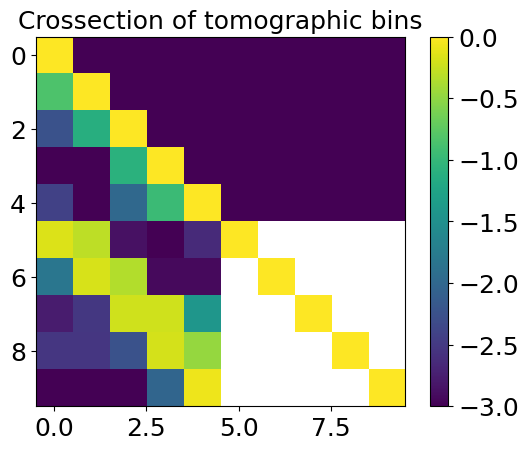

In [7]:
cross_sect = np.zeros((len(tomos), len(tomos)))
z = np.linspace(0, 3, 1000)
for i, (key1, tomo1) in enumerate(tomos.items()):
    for j, (key2, tomo2) in enumerate(tomos.items()):
            if key1.startswith("lens") and key2.startswith("lens") and i!=j:
                cross_sect[i, j] = np.nan
            else:
                if i >= j:
                    tomo1_z = tomo1["znodes"]
                    tomo2_z = tomo2["znodes"]
                    tomo1_photo_hists = tomo1["photo_hists"]
                    tomo2_photo_hists = tomo2["photo_hists"]
                    tomo1_mean = np.mean(tomo1_photo_hists, axis=1)
                    tomo2_mean = np.mean(tomo2_photo_hists, axis=1)
                    tomo1_mean = np.interp(z, tomo1_z, tomo1_mean)
                    tomo2_mean = np.interp(z, tomo2_z, tomo2_mean)
                    cross_sect[i, j] = np.trapz(tomo1_mean * tomo2_mean, z)
                else:
                    tomo1_z = ss_qp.tracers[key1].z
                    tomo2_z = ss_qp.tracers[key2].z
                    tomo1_mean = ss_qp.tracers[key1].nz
                    tomo2_mean = ss_qp.tracers[key2].nz
                    tomo1_mean = np.interp(z, tomo1_z, tomo1_mean)
                    tomo2_mean = np.interp(z, tomo2_z, tomo2_mean)
                    cross_sect[i, j] = np.trapz(tomo1_mean * tomo2_mean, z)
                
cross_sect_err = np.sqrt(np.diag(cross_sect))
cross_sect /= np.outer(cross_sect_err, cross_sect_err) 
plt.imshow(np.log10(cross_sect), cmap='viridis', vmin=-3, vmax=0)
plt.title('Crossection of tomographic bins')
plt.colorbar()

In [8]:
def make_nzs_plots(tracers_dict, tracer_list):
    n_tracers = len(tracer_list)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(tracer_list):
        nzs = tracers_dict[key].ensemble.objdata['pdfs']
        nz_fid = tracers_dict[key].nz
        z = tracers_dict[key].z
        nz_mean = np.mean(nzs, axis=0)
        axis[0,i].plot(z, (nzs.T)[:, :100], '-', color='C0', alpha=0.1)
        #axis[0,i].plot(z, nz_fid, '--', color="k")
        axis[0,i].plot(z, nz_mean, '-', color="k")
        cov = np.cov(nzs.T)
        err = np.sqrt(np.diag(cov))
        corr = cov/np.outer(err, err)
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].set_xlim([min(z), max(z)])
        axis[0,i].set_ylim([-0.001, 6.5])
        axis[0,i].set_title(key)
        if i == 0:
            axis[0,i].set_ylabel(r'$n(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(corr, aspect='auto',
                            origin='lower', cmap='coolwarm',
                            vmin=-1, vmax=1,
                            extent=[min(z), max(z), max(z), min(z)])
        axis[1,i].set_xlabel(r'$z$')
        if i > 0:
            axis[1,i].set_yticklabels([])

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()

In [9]:
tracer_list = ss_qp.tracers.keys()
for key in tracer_list:
    nzs = ss_qp.tracers[key].ensemble.objdata['pdfs']
    dndz = np.mean(nzs, axis=0)
    nzs = nzs.T
    z = ss_qp.tracers[key].z
    print(dndz.shape, z.shape, nzs.shape)
    file_name = f"{key}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/".format(method) + file_name
    np.savez(save_to, z=z, photo_hists=nzs, dndz=dndz)

(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)
(100,) (100,) (100, 10000)


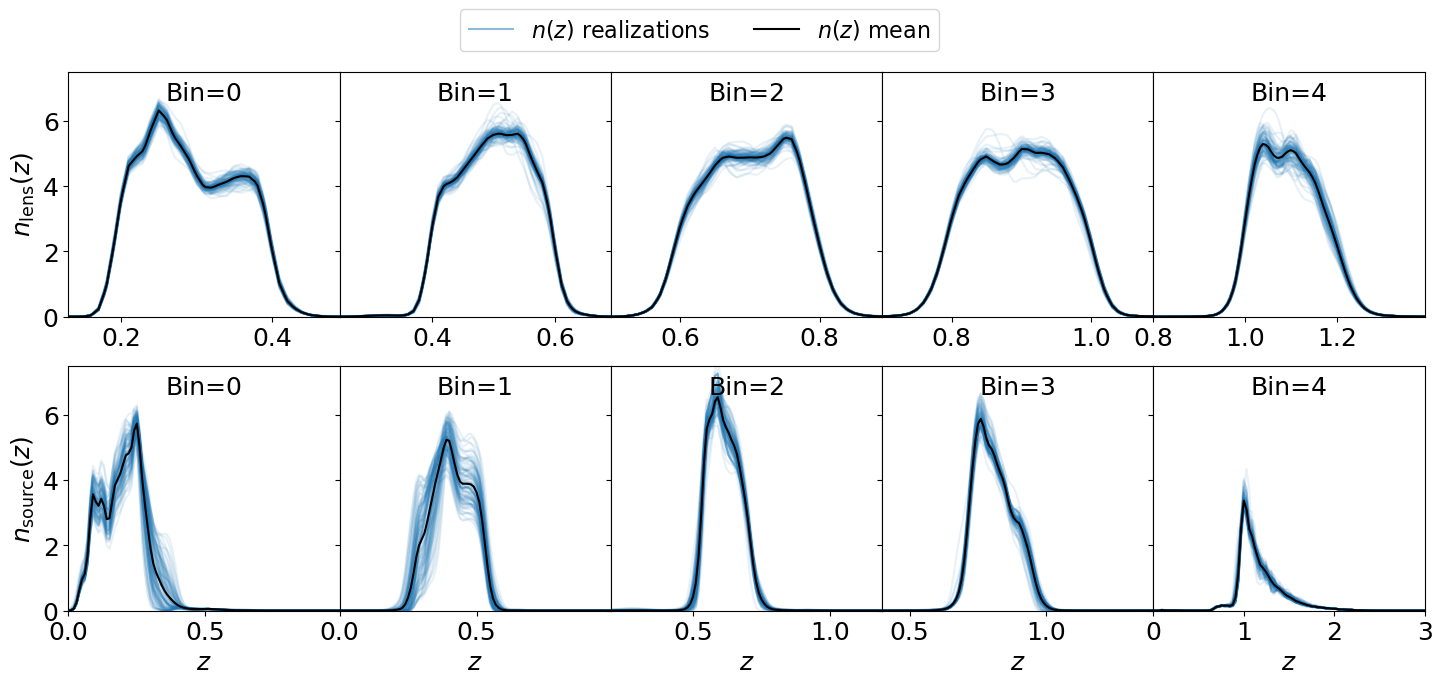

In [67]:
n_tracers = len(['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'])
figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
figure.subplots_adjust(wspace=0, hspace=0.2)
for i, key in enumerate(['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']):
    nzs = ss_qp.tracers[key].ensemble.objdata['pdfs']
    nz_fid = ss_qp.tracers[key].nz
    z = ss_qp.tracers[key].z
    nz_mean = np.mean(nzs, axis=0)
    axis[0,i].plot(z, nzs.T[:, :100], '-', color='C0', alpha=0.1)
    axis[0,i].plot(z, nz_mean, '-', color="k")
    nz_mean = np.mean(nzs, axis=1)
    axis[0,i].set_xlim([min(z), max(z)])
    axis[0,i].set_ylim([-0.001, 7.5])
    axis[0,i].set_title(f"Bin={i}", y=0.85)
    if i == 0:
        axis[0,i].set_ylabel(r'$n_{\rm lens}(z)$')
    else:
        axis[0,i].set_yticklabels([])
        axis[1,i].set_yticklabels([])
    axis[1,i].set_xlabel(r'$z$')
    if i > 0:
        axis[1,i].set_yticklabels([])
for i, key in enumerate(['source_0', 'source_1', 'source_2', 'source_3', 'source_4']):
    nzs = ss_qp.tracers[key].ensemble.objdata['pdfs']
    nz_fid = ss_qp.tracers[key].nz
    z = ss_qp.tracers[key].z
    nz_mean = np.mean(nzs, axis=0)
    axis[1,i].plot(z, nzs.T[:, :100], '-', color='C0', alpha=0.1)
    axis[1,i].plot(z, nzs.T[:, :1], '-', color='C0', alpha=0.5, label=r'$n(z)$ realizations')
    axis[1,i].plot(z, nz_mean, '-', color="k", label=r'$n(z)$ mean')
    nz_mean = np.mean(nzs, axis=1)
    axis[1,i].set_xlim([min(z), max(z)])
    axis[1,i].set_ylim([-0.001, 7.5])
    axis[1,i].set_title(f"Bin={i}", y=0.85)
    if i == 0:
        axis[1,i].set_ylabel(r'$n_{\rm source}(z)$')
    else:
        axis[1,i].set_yticklabels([])
    axis[1,i].set_xlabel(r'$z$')
    if i > 0:
        axis[1,i].set_yticklabels([])
plt.legend(loc='upper right', ncols=3, fontsize=16, bbox_to_anchor=(-0.75, 2.5))
plt.show()
figure.savefig(f"/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/Y1_nz_{method}.pdf", bbox_inches='tight', dpi=300)

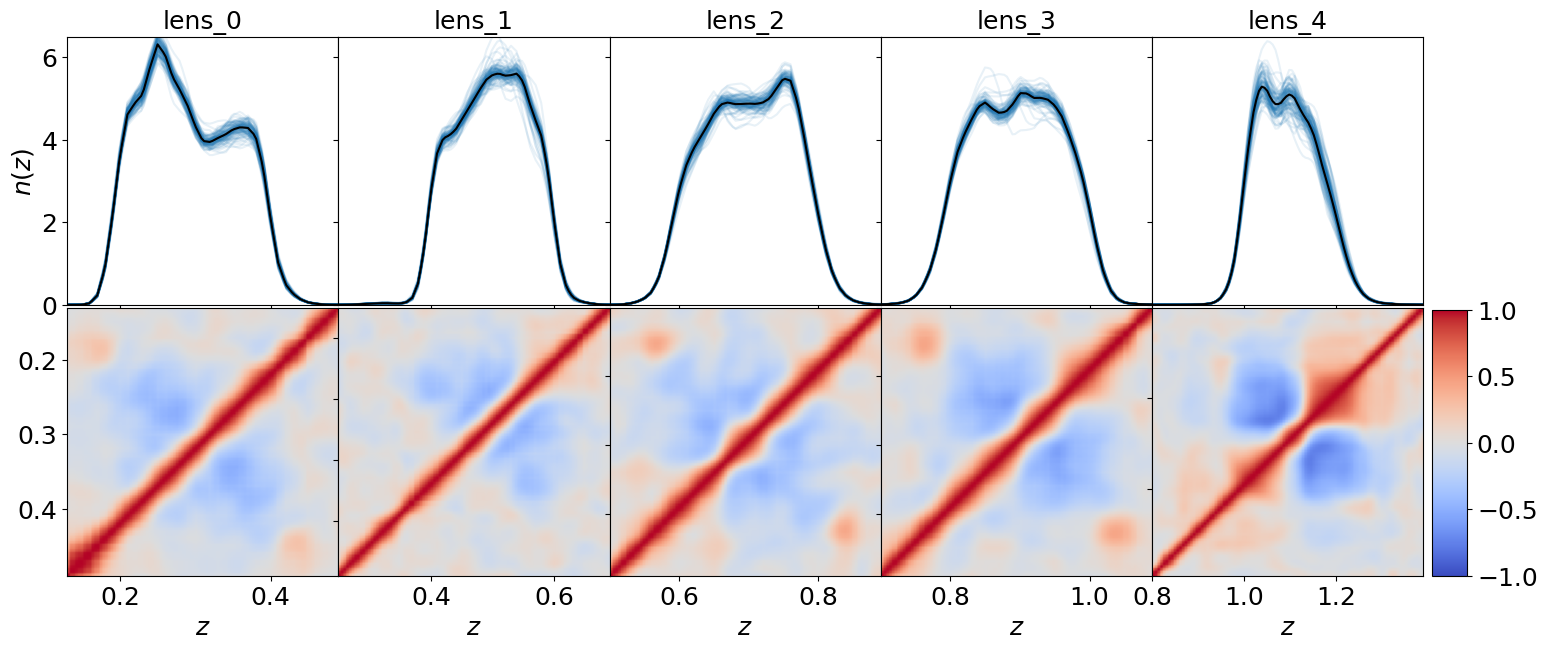

In [11]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(ss_qp.tracers, plot_tracers)

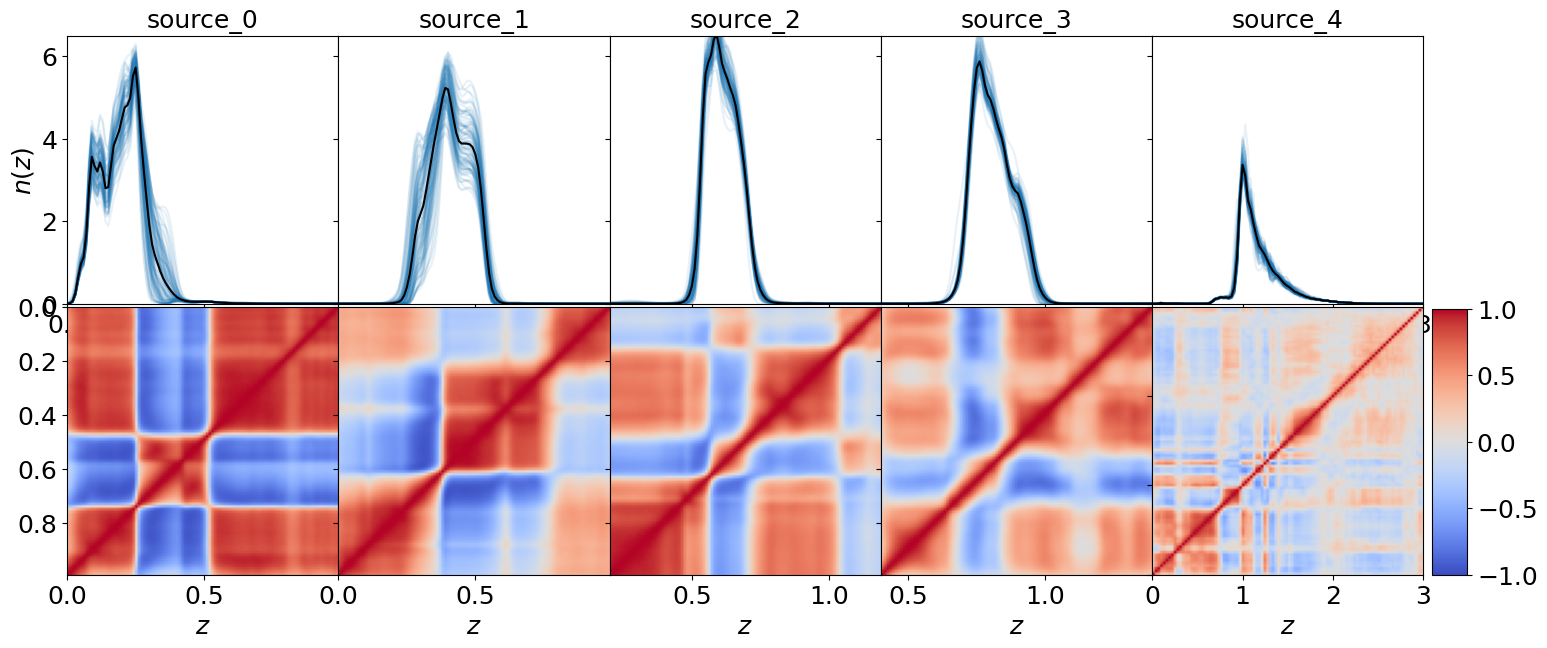

In [12]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(ss_qp.tracers, plot_tracers)

# Computing Uncertainties

Now we are just going to apply the methods of nz_prior described in the basic tutorial for each of the tracers in the sacc file. For the sake of brevity we will only use the qp tracers but the same can be done for the NZTracers.

## Shifts

In [13]:
shifts_priors = nzp.PriorSacc(ss_qp, 
                            model_name="Shifts",
                            compute_crosscorrs=crosscorrs_method)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [14]:
labels = [
    r"\Delta z^{\rm source \, 0}",
    r"\Delta z^{\rm source \, 1}",
    r"\Delta z^{\rm source \, 2}",
    r"\Delta z^{\rm source \, 3}",
    r"\Delta z^{\rm source \, 4}",
    r"\Delta z^{\rm lens \, 0}",
    r"\Delta z^{\rm lens \, 1}",
    r"\Delta z^{\rm lens \, 2}",
    r"\Delta z^{\rm lens \, 3}",
    r"\Delta z^{\rm lens \, 4}"]

Removed no burn in
Removed no burn in


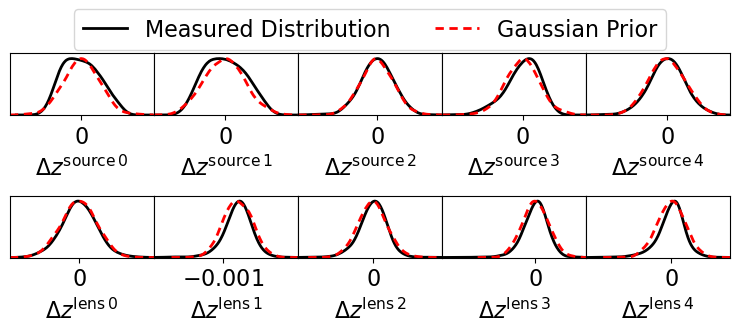

In [15]:
g = shifts_priors.plot_prior(mode="1D", add_prior=True, labels=labels, nx=5, legend_ncol=2, lws=2, ls=['-','--'])
g.export(f"/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/shifts_prior.pdf")

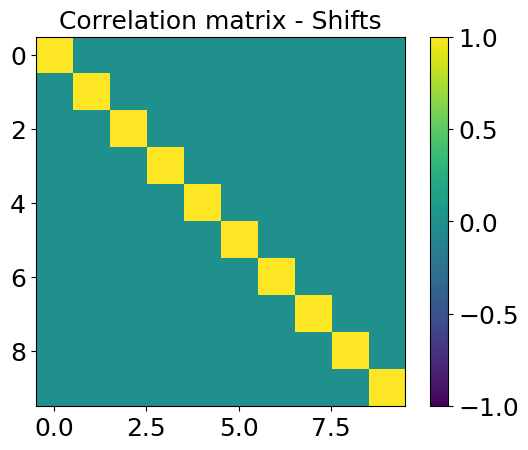

In [16]:
mean, cov, chol = shifts_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr, vmin=-1, vmax=1)
plt.title("Correlation matrix - Shifts")
plt.colorbar()

In [17]:
model_objs = shifts_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, cov, chol = model_obj.get_prior()
    file_name = f"dz_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/dz_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, cov=cov, chol=chol)

In [18]:
#shifted_nzs = {}
#for i in range(2000):
#    prior_sample = shifts_priors.sample_prior()
#    for tracer_name in list(ss_qp.tracers.keys()):
#        model_obj = shifts_priors.model_objs[tracer_name]
#        z = model_obj.z
#        nz =  model_obj.nz_mean
#        param_names = model_obj.get_params_names()
#        nz_names = [tracer_name + "__"  + name for name in param_names]
#        s = [prior_sample[nz_name] for nz_name in nz_names]
#        shifted_nz = nzp.shift_and_width_model(z, nz, s[0], 1)
#        if i == 0:
#            shifted_nzs[tracer_name] = [z, shifted_nz]
#        else:
#            shifted_nzs[tracer_name] = [z, np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]

shifted_nzs = {}
for i in range(1_000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = shifts_priors.model_objs[tracer_name]
        z = model_obj.z
        nz =  model_obj.nz_mean
        param = model_obj.params[:, i]
        shifted_nz = nzp.shift_and_width_model(z, nz, param, 1)
        if i == 0:
            shifted_nzs[tracer_name] = [z, shifted_nz]
        else:

            shifted_nzs[tracer_name] = [z, np.vstack([shifted_nzs[tracer_name][1], shifted_nz])]


In [19]:
shifted_params = {}
for name in list(shifts_priors.model_objs.keys()):
    model_obj = shifts_priors.model_objs[name]
    params = model_obj.params
    shifted_params[name] = params
    print(f"{name} params shape: {params.shape}")
np.savez("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/dz_priors/dz_params.npz".format(method), 
         nzs_lens_0=shifted_nzs['lens_0'][1].T,
         nzs_lens_1=shifted_nzs['lens_1'][1].T,
         nzs_lens_2=shifted_nzs['lens_2'][1].T,
         nzs_lens_3=shifted_nzs['lens_3'][1].T,
         nzs_lens_4=shifted_nzs['lens_4'][1].T,
         nzs_source_0=shifted_nzs['source_0'][1].T,
         nzs_source_1=shifted_nzs['source_1'][1].T,
         nzs_source_2=shifted_nzs['source_2'][1].T,
         nzs_source_3=shifted_nzs['source_3'][1].T,
         nzs_source_4=shifted_nzs['source_4'][1].T,
         lens_0=shifted_params['lens_0'],
         lens_1=shifted_params['lens_1'],
         lens_2=shifted_params['lens_2'],
         lens_3=shifted_params['lens_3'],
         lens_4=shifted_params['lens_4'],
         source_0=shifted_params['source_0'],
         source_1=shifted_params['source_1'],
         source_2=shifted_params['source_2'],
         source_3=shifted_params['source_3'],
         source_4=shifted_params['source_4'])

source_0 params shape: (1, 10000)
source_1 params shape: (1, 10000)
source_2 params shape: (1, 10000)
source_3 params shape: (1, 10000)
source_4 params shape: (1, 10000)
lens_0 params shape: (1, 10000)
lens_1 params shape: (1, 10000)
lens_2 params shape: (1, 10000)
lens_3 params shape: (1, 10000)
lens_4 params shape: (1, 10000)


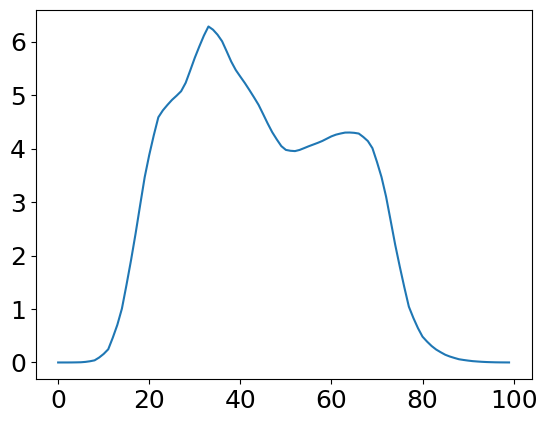

In [20]:
test_nzs = np.load("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/dz_priors/dz_params.npz".format(method))
plt.plot(np.mean(test_nzs['nzs_lens_0'], axis=1))

In [21]:
ss_qp_shifted = update_sacc_qp(ss_qp, shifted_nzs)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  1   2   3   3   4   5   5   6   6  12  12  16  16  16  17  18  23  24
  24  29  31  33  34  36  37  37  37  39  41  42  42  42  46  46  46  49
  56  64  67  67  71  72  72  73  73  75  75  77  77  78  81  83  83  86
  86  91  91  92  93  95  96 104 104 109 110 110 112 115 118 118 120 121
 121 121 124 127 127 129 129 131 131 131 132 132 133 137 141 142 143 143
 146 146 149 149 151 156 156 160 161 162 163 163 164 164 166 166 168 168
 173 174 174 175 177 184 184 187 193 195 199 199 200 200 200 203 203 203
 207 207 209 209 209 213 215 216 217 217 221 221 223 223 226 237 237 238
 240 240 241 241 245 245 247 252 252 252 252 253 259 259 262 264 267 268
 270 270 271 271 273 274 275 275 277 280 281 284 286 286 290 291 297 300
 305 306 306 306 307 310 313 318 318 319 323 323 324 324 324 327 329 330
 331 332 332 335 

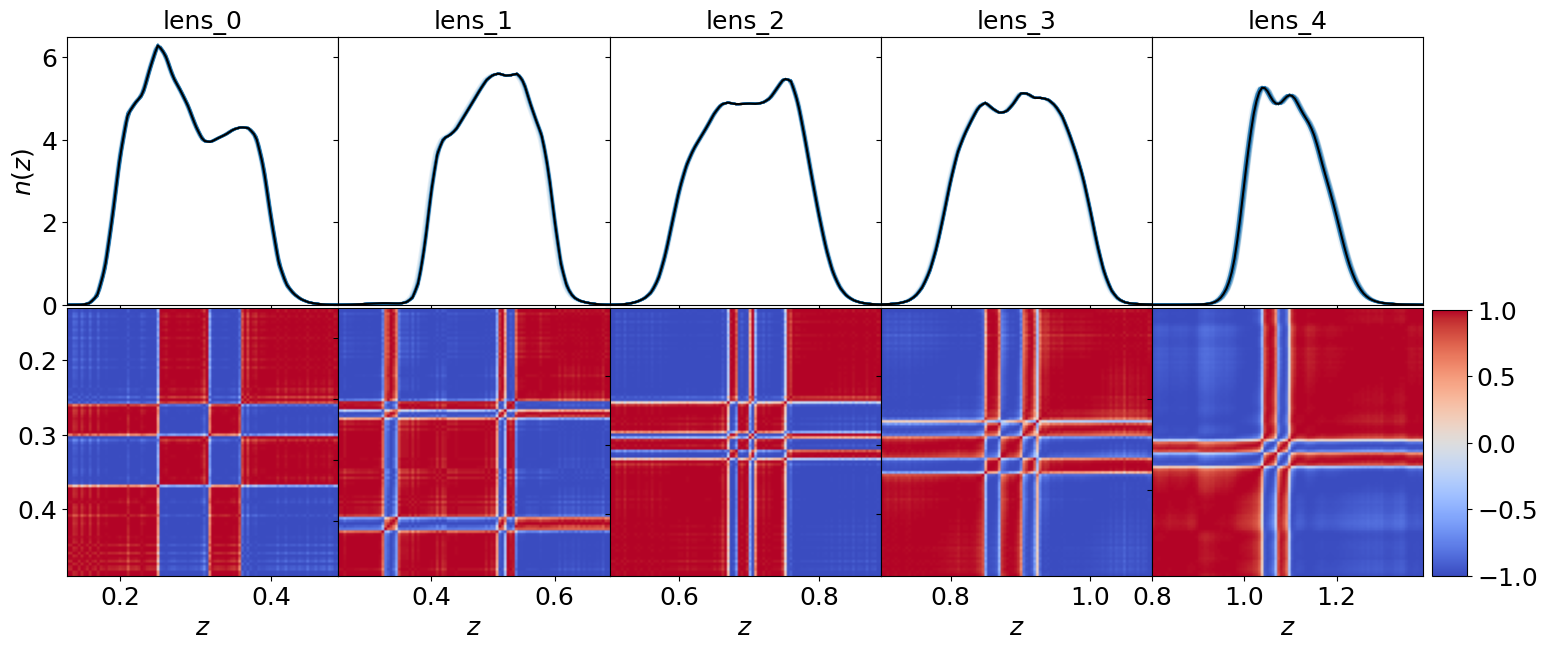

In [22]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(ss_qp_shifted.tracers, plot_tracers)

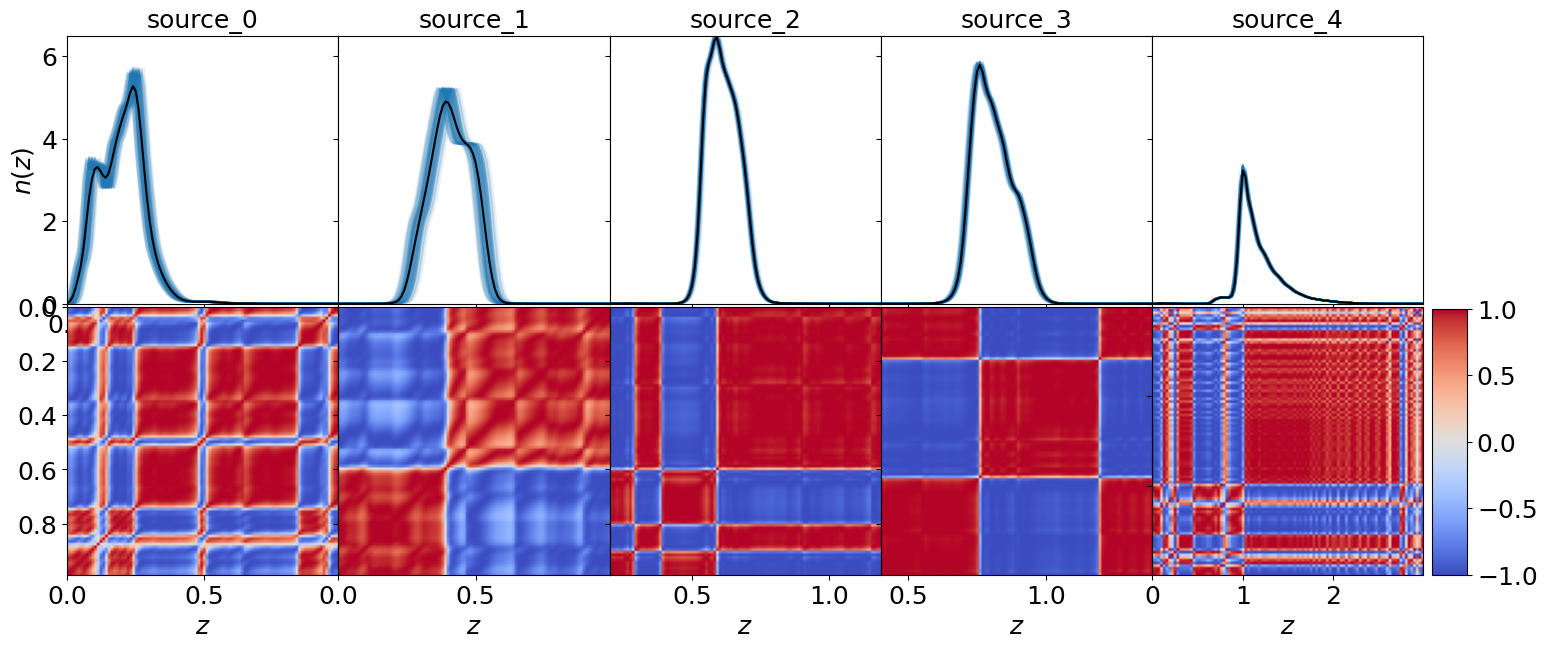

In [23]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(ss_qp_shifted.tracers, plot_tracers)

## Shifts & widths

In [24]:
SnWs_priors = nzp.PriorSacc(ss_qp, 
                            model_name="ShiftsWidths",
                            compute_crosscorrs=crosscorrs_method)

Making model for  source_0
Gaussianity test diff:  91.47824754925571
Optimizing widths:  True
Making model for  source_1
Gaussianity test diff:  99.169723747517
Optimizing widths:  True
Making model for  source_2
Gaussianity test diff:  91.80049797163288
Optimizing widths:  True
Making model for  source_3
Gaussianity test diff:  97.07404470901675
Optimizing widths:  True
Making model for  source_4
Gaussianity test diff:  105.93375361457949
Optimizing widths:  True
Making model for  lens_0
Gaussianity test diff:  281.64619547209816
Optimizing widths:  True
Making model for  lens_1
Gaussianity test diff:  216.48817861135507
Optimizing widths:  True
Making model for  lens_2
Gaussianity test diff:  241.45801829336617
Optimizing widths:  True
Making model for  lens_3
Gaussianity test diff:  245.02141765900768
Optimizing widths:  True
Making model for  lens_4
Gaussianity test diff:  161.9787575768283
Optimizing widths:  True


In [25]:
labels = np.array([
    r"\Delta z^{\rm source \, 0}",
    r"w_z^{\rm source \, 0}",
    r"\Delta z^{\rm source \, 1}",
    r"w_z^{\rm source \, 1}",
    r"\Delta z^{\rm source \, 2}",
    r"w_z^{\rm source \, 2}",
    r"\Delta z^{\rm source \, 3}",
    r"w_z^{\rm source \, 3}",
    r"\Delta z^{\rm source \, 4}",
    r"w_z^{\rm source \, 4}",
    r"\Delta z^{\rm lens \, 0}",
    r"w_z^{\rm lens \, 0}",
    r"\Delta z^{\rm lens \, 1}",
    r"w_z^{\rm lens \, 1}",
    r"\Delta z^{\rm lens \, 2}",
    r"w_z^{\rm lens \, 2}",
    r"\Delta z^{\rm lens \, 3}",
    r"w_z^{\rm lens \, 3}",
    r"\Delta z^{\rm lens \, 4}",
    r"w_z^{\rm lens \, 4}"
])

In [26]:
order = [0, 2, 4, 6, 8, 1, 3, 5, 7, 9,
        10, 12, 14, 16, 18, 11, 13, 15, 17, 19]

Order:  [0, 2, 4, 6, 8, 1, 3, 5, 7, 9, 10, 12, 14, 16, 18, 11, 13, 15, 17, 19]
Removed no burn in
Removed no burn in


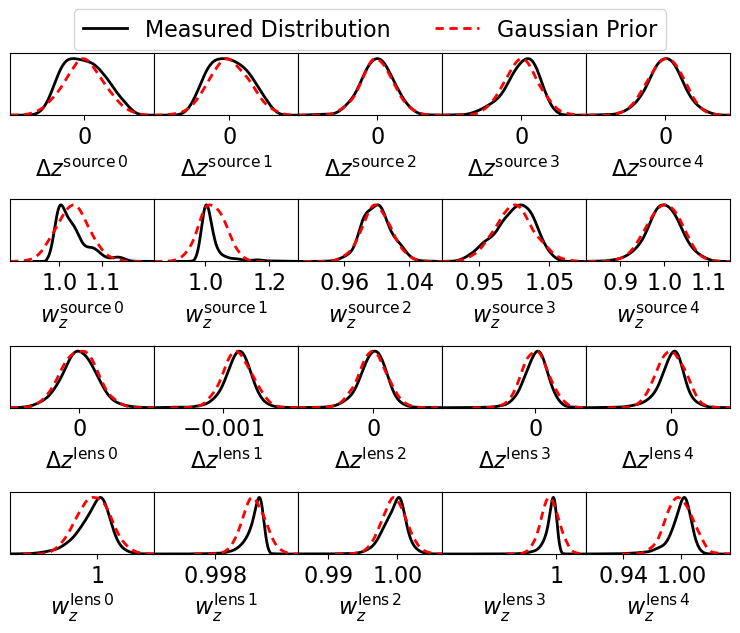

In [27]:
g = SnWs_priors.plot_prior(
    order=order,
    labels=labels, 
    mode="1D", 
    nx=5, 
    legend_ncol=2, 
    lws=2, 
    ls=['-','--'])
g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/SnWs_prior.pdf")

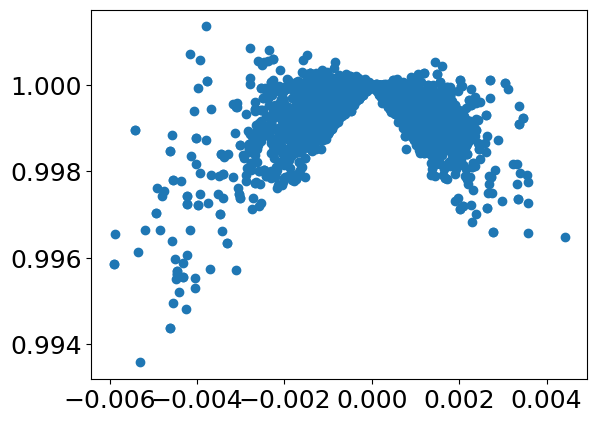

In [28]:
tomo_name = "lens_1"
plt.scatter(np.array(SnWs_priors.model_objs[tomo_name].shifts),
            np.array(SnWs_priors.model_objs[tomo_name].widths))

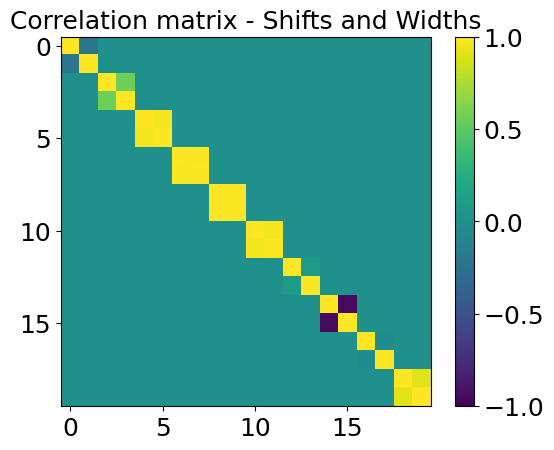

In [29]:
mean, cov, chol = SnWs_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr, vmin=-1, vmax=1)
plt.title("Correlation matrix - Shifts and Widths")
plt.colorbar()

In [30]:
model_objs = SnWs_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, cov, chol = model_obj.get_prior()
    file_name = f"wzdz_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/wzdz_priors/".format(method) + file_name
    np.savez(save_to, z=z, dndz=mean, cov=cov, chol=chol)

In [31]:
#SnWs_nzs = {}
#for i in range(2000):
#    prior_sample = SnWs_priors.sample_prior()
#    for tracer_name in list(ss_qp.tracers.keys()):
#        model_obj = SnWs_priors.model_objs[tracer_name]
#        z = model_obj.z
#        nz = model_obj.nz_mean
#        param_names = model_obj.get_params_names()
#        nz_names = [tracer_name + "__"  + name for name in param_names]
#        s, w = [prior_sample[nz_name] for nz_name in nz_names]
#        shifted_nz = nzp.shift_and_width_model(z, nz, s, w)
#        if i == 0:
#            SnWs_nzs[tracer_name] = [z, shifted_nz]
#        else:
#            SnWs_nzs[tracer_name] = [z, np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]

SnWs_nzs = {}
for i in range(1_000):
    for tracer_name in list(ss_qp.tracers.keys()):
        model_obj = SnWs_priors.model_objs[tracer_name]
        z = model_obj.z
        nz = model_obj.nz_mean
        param = model_obj.params[:, i]
        s = param[0]
        w = param[1]
        shifted_nz = nzp.shift_and_width_model(z, nz, s, w)
        if i == 0:
            SnWs_nzs[tracer_name] = [z, shifted_nz]
        else:

            SnWs_nzs[tracer_name] = [z, np.vstack([SnWs_nzs[tracer_name][1], shifted_nz])]

In [32]:
SnWs_params = {}
for name in list(SnWs_priors.model_objs.keys()):
    model_obj = SnWs_priors.model_objs[name]
    param = model_obj.params
    SnWs_params[name] = param
    print(f"{name} params shape: {param.shape}")
np.savez("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/wzdz_priors/wzdz_params.npz".format(method), 
         nzs_lens_0=SnWs_nzs['lens_0'][1].T,
         nzs_lens_1=SnWs_nzs['lens_1'][1].T,
         nzs_lens_2=SnWs_nzs['lens_2'][1].T,
         nzs_lens_3=SnWs_nzs['lens_3'][1].T,
         nzs_lens_4=SnWs_nzs['lens_4'][1].T,
         nzs_source_0=SnWs_nzs['source_0'][1].T,
         nzs_source_1=SnWs_nzs['source_1'][1].T,
         nzs_source_2=SnWs_nzs['source_2'][1].T,
         nzs_source_3=SnWs_nzs['source_3'][1].T,
         nzs_source_4=SnWs_nzs['source_4'][1].T,
         lens_0=SnWs_params['lens_0'],
         lens_1=SnWs_params['lens_1'],
         lens_2=SnWs_params['lens_2'],
         lens_3=SnWs_params['lens_3'],
         lens_4=SnWs_params['lens_4'],
         source_0=SnWs_params['source_0'],
         source_1=SnWs_params['source_1'],
         source_2=SnWs_params['source_2'],
         source_3=SnWs_params['source_3'],
         source_4=SnWs_params['source_4'])

source_0 params shape: (2, 10000)
source_1 params shape: (2, 10000)
source_2 params shape: (2, 10000)
source_3 params shape: (2, 10000)
source_4 params shape: (2, 10000)
lens_0 params shape: (2, 10000)
lens_1 params shape: (2, 10000)
lens_2 params shape: (2, 10000)
lens_3 params shape: (2, 10000)
lens_4 params shape: (2, 10000)


In [33]:
SnWs_ss_qp = update_sacc_qp(ss_qp, SnWs_nzs)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  1   2   3   4   5   6  12  16  17  24  29  31  33  34  36  37  41  42
  46  56  64  67  71  72  73  75  77  78  81  83  86  91  92  93  95  96
 104 109 110 112 115 118 120 121 127 129 131 132 133 137 142 143 146 149
 151 156 159 160 161 162 163 164 166 168 173 174 175 177 184 187 193 195
 199 200 203 207 209 213 215 216 217 221 223 226 237 238 240 241 245 247
 252 252 259 264 267 268 270 271 273 275 277 281 284 286 290 291 297 300
 305 306 307 308 313 318 319 323 324 327 329 330 332 335 336 338 339 347
 348 349 350 351 352 353 354 355 356 357 359 363 370 378 380 381 385 386
 390 391 393 399 403 405 408 412 414 414 416 419 421 424 431 433 434 435
 437 438 440 441 443 444 448 449 452 455 458 460 461 467 468 470 477 478
 479 488 489 494 496 497 500 501 502 505 506 508 511 512 514 518 519 524
 526 529 530 531 

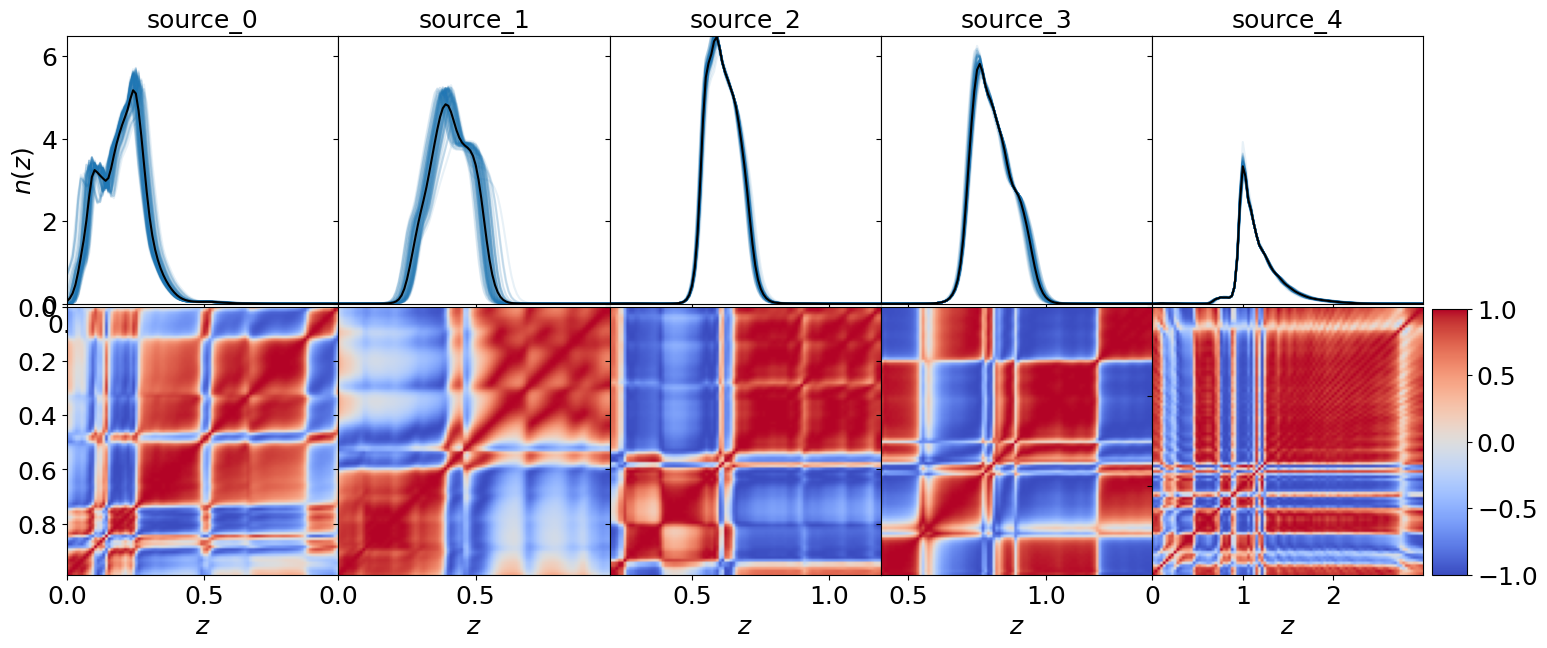

In [34]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(SnWs_ss_qp.tracers, plot_tracers)

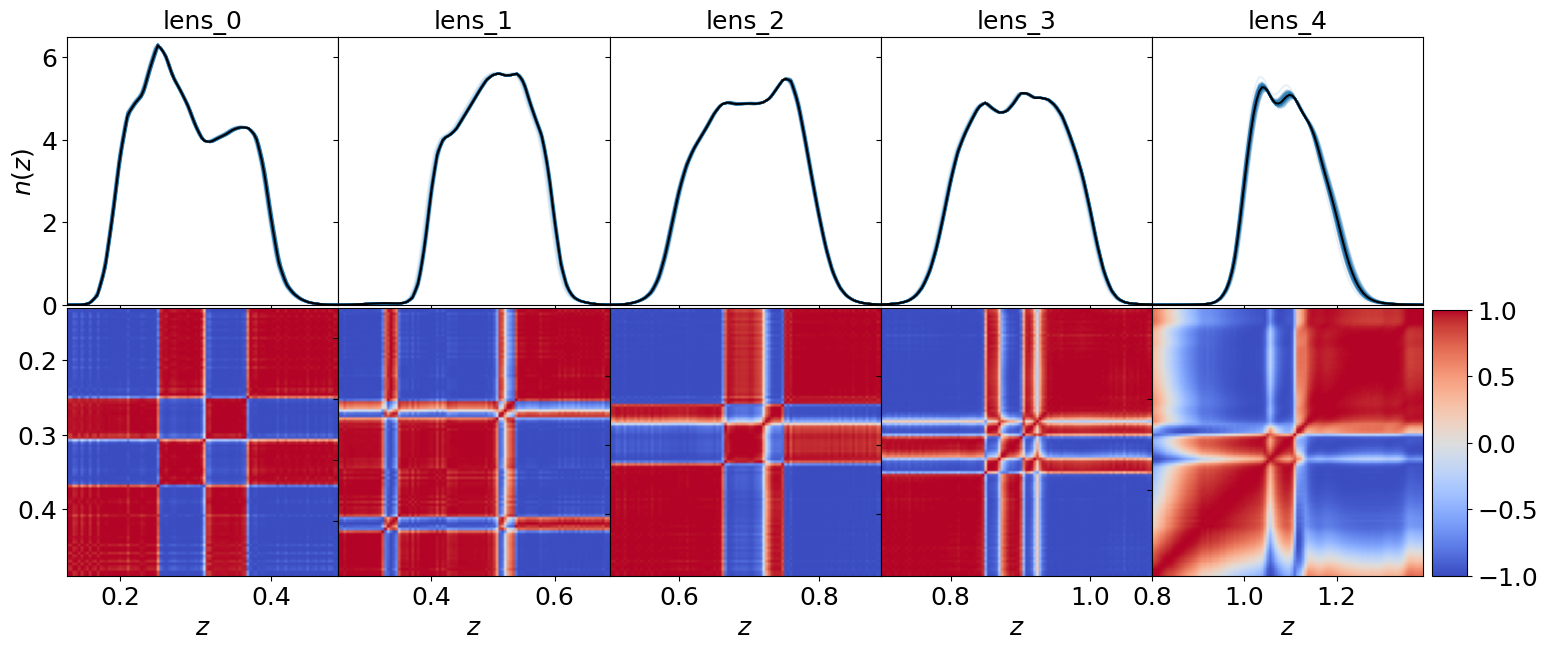

In [35]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(SnWs_ss_qp.tracers, plot_tracers)

## GP

In [36]:
n=5
gp_priors = nzp.PriorSacc(ss_qp,
                            model_name="GP",
                            compute_crosscorrs=crosscorrs_method,
                            nparams=n)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


In [37]:
self = gp_priors.model_objs['source_1']
n1, m1 = self.Ws.shape
n2, m2 = self.nzs.shape
nzqs = np.zeros((n1, m2 + m1))
nzqs[:, :m2] = self.nzs
nzqs[:, m2:] = self.Ws
nzq_mean = np.mean(nzqs, axis=0)
dnzqs = nzqs - nzq_mean
cov_zzqq = np.cov(dnzqs.T)
cov_zz = cov_zzqq[:len(self.nz_mean), :len(self.nz_mean)]
cov_qq = cov_zzqq[len(self.nz_mean) :, len(self.nz_mean) :]
cov_zq = cov_zzqq[: len(self.nz_mean), len(self.nz_mean) :]
inv_cov_qq = np.linalg.pinv(cov_qq)
wiener = np.dot(cov_zq, inv_cov_qq)

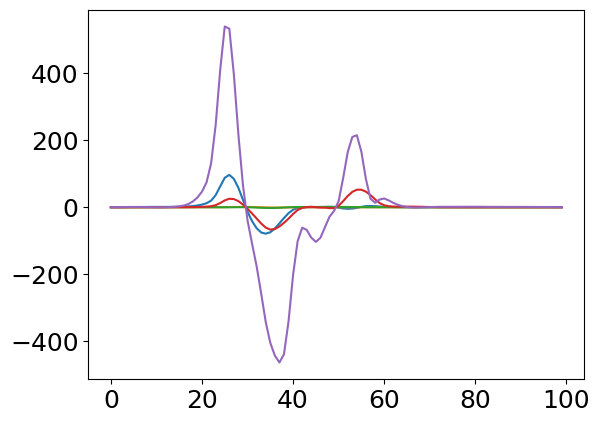

In [38]:
plt.plot(wiener);

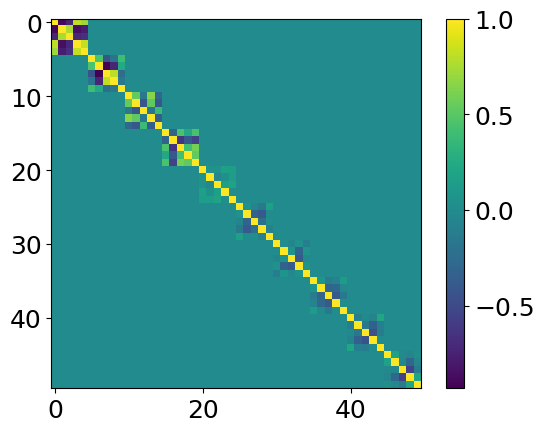

In [39]:
mean, cov, chol = gp_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(corr)
plt.colorbar()

In [40]:
labels = [
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 0}" for q in gp_priors.model_objs['source_0'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 1}" for q in gp_priors.model_objs['source_1'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 2}" for q in gp_priors.model_objs['source_2'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 3}" for q in gp_priors.model_objs['source_3'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm source \, 4}" for q in gp_priors.model_objs['source_4'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 0}" for q in gp_priors.model_objs['lens_0'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 1}" for q in gp_priors.model_objs['lens_1'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 2}" for q in gp_priors.model_objs['lens_2'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 3}" for q in gp_priors.model_objs['lens_3'].q],
    [r"\alpha_{"+ "z={i}".format(i=round(q, 3))+r"}^{\rm lens \, 4}" for q in gp_priors.model_objs['lens_4'].q],
]
labels = np.array(labels).flatten()

In [41]:
#g = gp_priors.plot_prior(mode="1D", add_prior=True, labels=labels, nx=5, legend_ncol=2, lws=2, ls=['-','--'])
#g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/gp_priors.pdf")

In [42]:
model_objs = gp_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    #W = W @ chol
    file_name = f"gp_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/gp_{}_priors/".format(method, n) + file_name
    np.savez(save_to, z=z, dndz=mean, W=W, chol=chol)

In [43]:
gp_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = gp_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    z = model_obj.z
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    W = W #@ chol
    _nzs = np.array([nzp.linear_model(z, nz_mean, W, model_obj.params[:, i]-np.mean(gp_priors.model_objs[tracer_name].params, axis=1)) for i in range(1_000)])
    gp_nzs[tracer_name] = [z, _nzs]

In [44]:
gp_params = {}
for name in list(gp_priors.model_objs.keys()):
    model_obj = gp_priors.model_objs[name]
    params = model_obj.params
    params -= np.mean(params, axis=1, keepdims=True)
    gp_params[name] = params
    print(f"{name} params shape: {params.shape}")
np.savez("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/gp_{}_priors/gp_params.npz".format(method, n), 
         nzs_lens_0=gp_nzs['lens_0'][1].T,
         nzs_lens_1=gp_nzs['lens_1'][1].T,
         nzs_lens_2=gp_nzs['lens_2'][1].T,
         nzs_lens_3=gp_nzs['lens_3'][1].T,
         nzs_lens_4=gp_nzs['lens_4'][1].T,
         nzs_source_0=gp_nzs['source_0'][1].T,
         nzs_source_1=gp_nzs['source_1'][1].T,
         nzs_source_2=gp_nzs['source_2'][1].T,
         nzs_source_3=gp_nzs['source_3'][1].T,
         nzs_source_4=gp_nzs['source_4'][1].T,
         lens_0=gp_params['lens_0'],
         lens_1=gp_params['lens_1'],
         lens_2=gp_params['lens_2'],
         lens_3=gp_params['lens_3'],
         lens_4=gp_params['lens_4'],
         source_0=gp_params['source_0'],
         source_1=gp_params['source_1'],
         source_2=gp_params['source_2'],
         source_3=gp_params['source_3'],
         source_4=gp_params['source_4'])

source_0 params shape: (5, 10000)
source_1 params shape: (5, 10000)
source_2 params shape: (5, 10000)
source_3 params shape: (5, 10000)
source_4 params shape: (5, 10000)
lens_0 params shape: (5, 10000)
lens_1 params shape: (5, 10000)
lens_2 params shape: (5, 10000)
lens_3 params shape: (5, 10000)
lens_4 params shape: (5, 10000)


In [45]:
gp_ss_qp = update_sacc_qp(ss_qp, gp_nzs)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  1   1   1 ... 996 996 997]
  warnings.warn(
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  0   0   0 ... 998 998 999]
  warnings.warn(
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  1   1   1 ... 997 997 999]
  warnings.warn(
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  2   2   2 ... 996 997 998]
  warnings.warn(
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hi

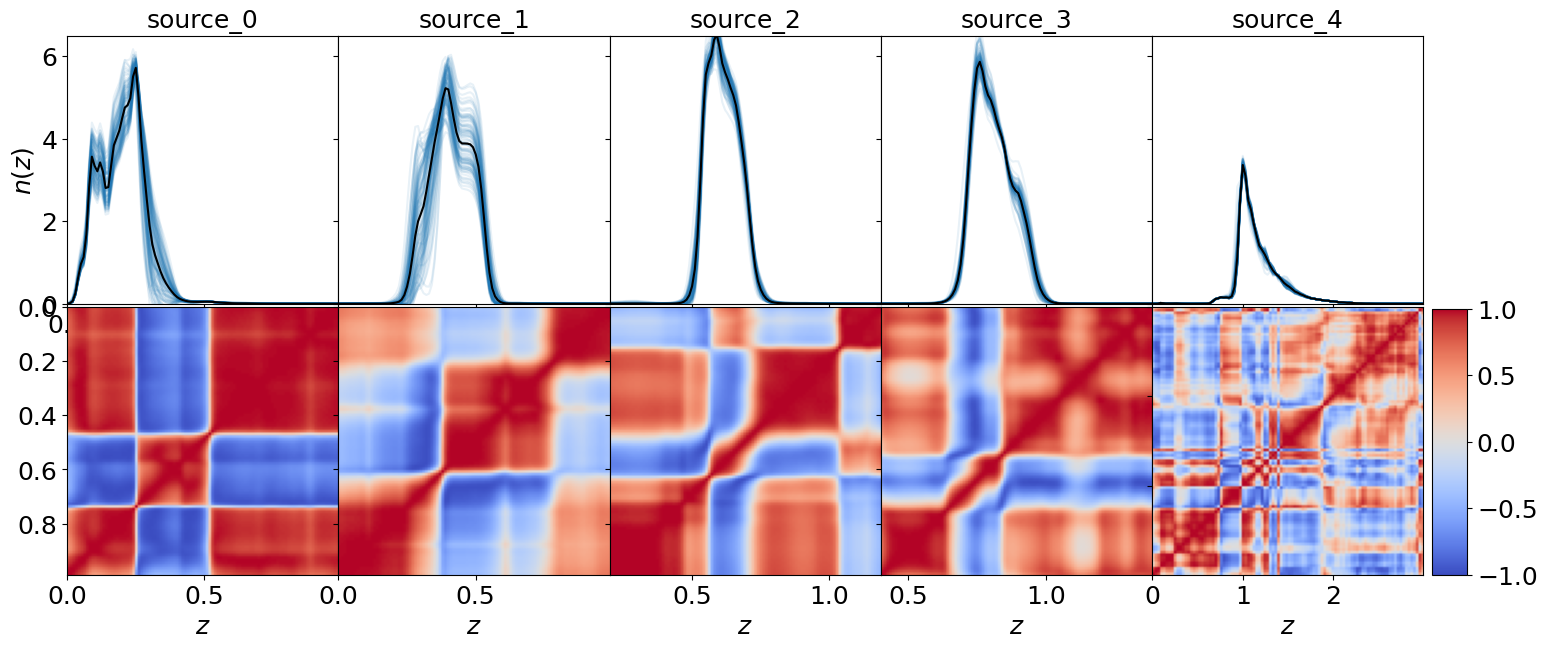

In [46]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(gp_ss_qp.tracers, plot_tracers)

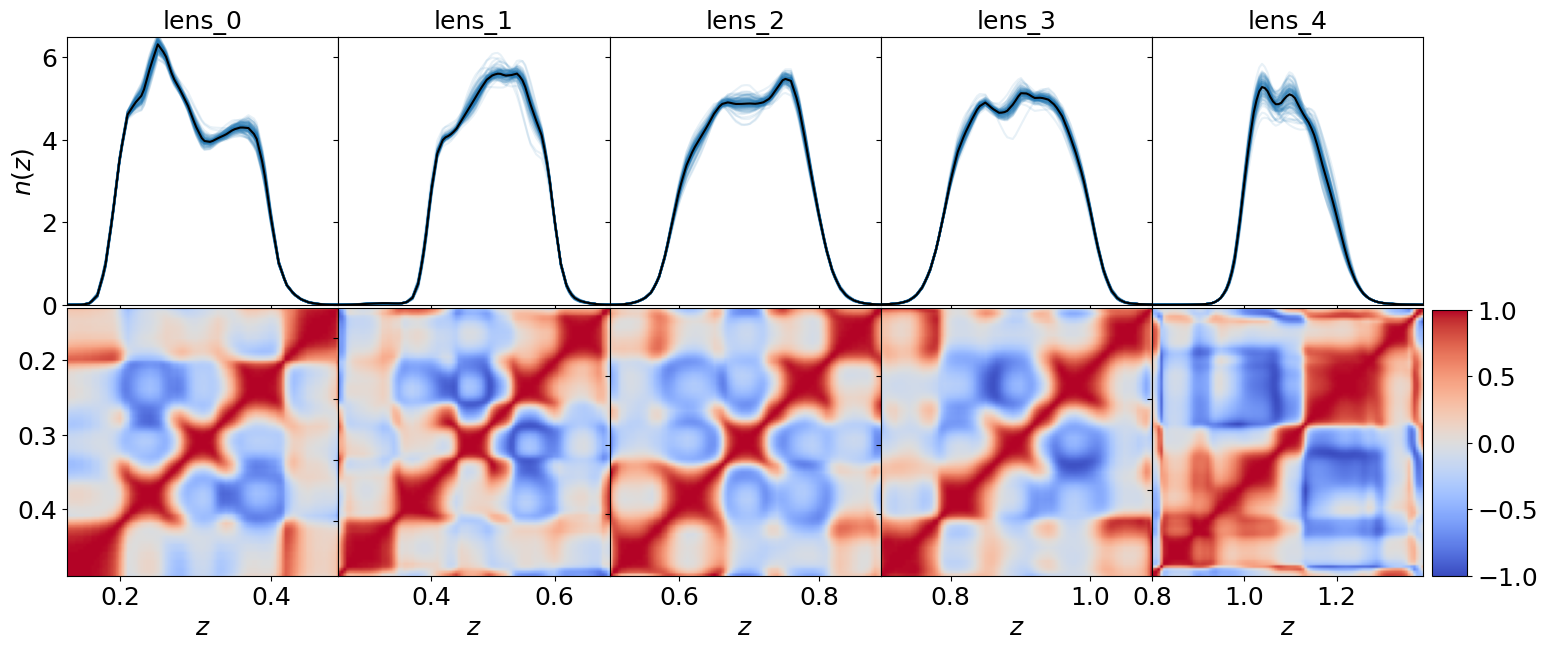

In [47]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(gp_ss_qp.tracers, plot_tracers)

# PCA

In [48]:
n = 5
PCA_priors = nzp.PriorSacc(ss_qp,
                            model_name="PCA",
                            compute_crosscorrs=crosscorrs_method,
                            nparams=n)

Making model for  source_0
Making model for  source_1
Making model for  source_2
Making model for  source_3
Making model for  source_4
Making model for  lens_0
Making model for  lens_1
Making model for  lens_2
Making model for  lens_3
Making model for  lens_4


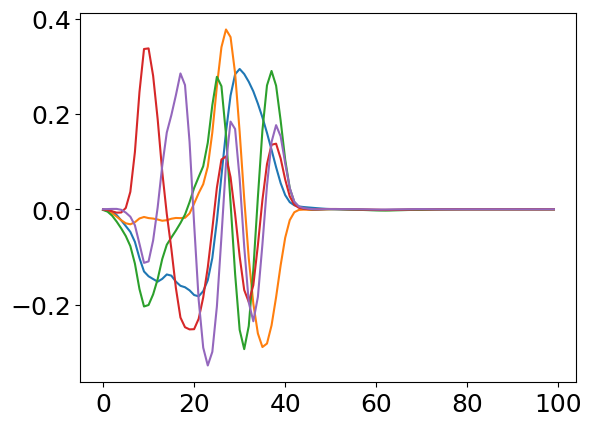

In [49]:
plt.plot(PCA_priors.model_objs['source_0'].funcs);

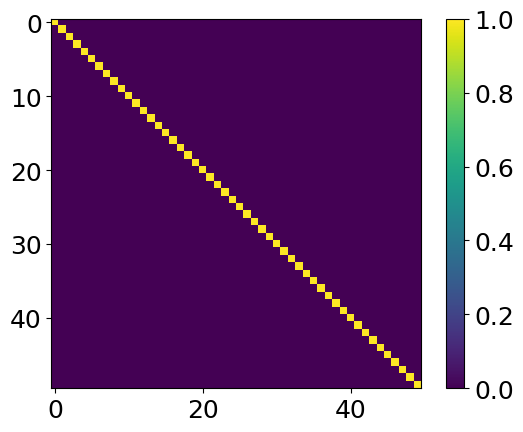

In [50]:
mean, cov, chol = PCA_priors.get_prior()
err = np.sqrt(np.diag(cov))
corr = cov/np.outer(err, err) 
plt.imshow(np.sqrt(abs(corr)))
plt.colorbar()

In [51]:
labels = [
    r"\alpha_{1}^{\rm source \, 0}",
    r"\alpha_{2}^{\rm source \, 0}",
    r"\alpha_{3}^{\rm source \, 0}",
    r"\alpha_{4}^{\rm source \, 0}",
    r"\alpha_{5}^{\rm source \, 0}",
    r"\alpha_{1}^{\rm source \, 1}",
    r"\alpha_{2}^{\rm source \, 1}",
    r"\alpha_{3}^{\rm source \, 1}",
    r"\alpha_{4}^{\rm source \, 1}",
    r"\alpha_{5}^{\rm source \, 1}",
    r"\alpha_{1}^{\rm source \, 2}",
    r"\alpha_{2}^{\rm source \, 2}",
    r"\alpha_{3}^{\rm source \, 2}",
    r"\alpha_{4}^{\rm source \, 2}",
    r"\alpha_{5}^{\rm source \, 2}",
    r"\alpha_{1}^{\rm source \, 3}",
    r"\alpha_{2}^{\rm source \, 3}",
    r"\alpha_{3}^{\rm source \, 3}",
    r"\alpha_{4}^{\rm source \, 3}",
    r"\alpha_{5}^{\rm source \, 3}",
    r"\alpha_{1}^{\rm source \, 4}",
    r"\alpha_{2}^{\rm source \, 4}",
    r"\alpha_{3}^{\rm source \, 4}",
    r"\alpha_{4}^{\rm source \, 4}",
    r"\alpha_{5}^{\rm source \, 4}",
    r"\alpha_{1}^{\rm lens \, 0}",
    r"\alpha_{2}^{\rm lens \, 0}",
    r"\alpha_{3}^{\rm lens \, 0}",
    r"\alpha_{4}^{\rm lens \, 0}",
    r"\alpha_{5}^{\rm lens \, 0}",
    r"\alpha_{1}^{\rm lens \, 1}",
    r"\alpha_{2}^{\rm lens \, 1}",
    r"\alpha_{3}^{\rm lens \, 1}",
    r"\alpha_{4}^{\rm lens \, 1}",
    r"\alpha_{5}^{\rm lens \, 1}",
    r"\alpha_{1}^{\rm lens \, 2}",
    r"\alpha_{2}^{\rm lens \, 2}",
    r"\alpha_{3}^{\rm lens \, 2}",
    r"\alpha_{4}^{\rm lens \, 2}",
    r"\alpha_{5}^{\rm lens \, 2}",
    r"\alpha_{1}^{\rm lens \, 3}",
    r"\alpha_{2}^{\rm lens \, 3}",
    r"\alpha_{3}^{\rm lens \, 3}",
    r"\alpha_{4}^{\rm lens \, 3}",
    r"\alpha_{5}^{\rm lens \, 3}",
    r"\alpha_{1}^{\rm lens \, 4}",
    r"\alpha_{2}^{\rm lens \, 4}",
    r"\alpha_{3}^{\rm lens \, 4}",
    r"\alpha_{4}^{\rm lens \, 4}",
    r"\alpha_{5}^{\rm lens \, 4}",
]

In [52]:
#g = PCA_priors.plot_prior(mode="1D", add_prior=True, nx=5, labels=labels, legend_ncol=2, lws=2, ls=['-','--'])
#g.export("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/pca_priors.pdf")

In [53]:
model_objs = PCA_priors.model_objs
for name in list(model_objs.keys()):
    model_obj = model_objs[name]
    z = model_obj.z
    mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    W = model_obj.funcs
    #W = W @ chol
    file_name = f"PCA_{name}.npz"
    save_to = "/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/PCA_{}_priors/".format(method, n) + file_name
    np.savez(save_to, z=z, dndz=mean, W=W, chol=chol)


In [54]:
pca_nzs = {}
for tracer_name in list(ss_qp.tracers.keys()):
    model_obj = PCA_priors.model_objs[tracer_name]
    nz_mean = model_obj.nz_mean
    _, _, chol = model_obj.get_prior()
    z = model_obj.z
    W = model_obj.funcs
    #W = W @ chol
    _nzs = np.array([nzp.linear_model(z, nz_mean, W, model_obj.params[:, i]) for i in range(1_000)])
    pca_nzs[tracer_name] = [z, _nzs]

In [55]:
pca_params = {}
for name in list(PCA_priors.model_objs.keys()):
    model_obj = PCA_priors.model_objs[name]
    params = model_obj.params
    pca_params[name] = params
    print(f"{name} params shape: {params.shape}")
np.savez("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/nzs_{}/PCA_{}_priors/pca_params.npz".format(method, n), 
        nzs_lens_0=pca_nzs['lens_0'][1].T,
        nzs_lens_1=pca_nzs['lens_1'][1].T,
        nzs_lens_2=pca_nzs['lens_2'][1].T,
        nzs_lens_3=pca_nzs['lens_3'][1].T,
        nzs_lens_4=pca_nzs['lens_4'][1].T,
        nzs_source_0=pca_nzs['source_0'][1].T,
        nzs_source_1=pca_nzs['source_1'][1].T,
        nzs_source_2=pca_nzs['source_2'][1].T,
        nzs_source_3=pca_nzs['source_3'][1].T,
        nzs_source_4=pca_nzs['source_4'][1].T,
         lens_0=pca_params['lens_0'],
         lens_1=pca_params['lens_1'],
         lens_2=pca_params['lens_2'],
         lens_3=pca_params['lens_3'],
         lens_4=pca_params['lens_4'],
         source_0=pca_params['source_0'],
         source_1=pca_params['source_1'],
         source_2=pca_params['source_2'],
         source_3=pca_params['source_3'],
         source_4=pca_params['source_4'])

source_0 params shape: (5, 10000)
source_1 params shape: (5, 10000)
source_2 params shape: (5, 10000)
source_3 params shape: (5, 10000)
source_4 params shape: (5, 10000)
lens_0 params shape: (5, 10000)
lens_1 params shape: (5, 10000)
lens_2 params shape: (5, 10000)
lens_3 params shape: (5, 10000)
lens_4 params shape: (5, 10000)


In [56]:
pca_ss_qp = update_sacc_qp(ss_qp, pca_nzs)

/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  1   1   1 ... 996 996 996]
  warnings.warn(
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  0   0   0 ... 997 997 997]
  warnings.warn(
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  1   1   1 ... 992 996 996]
  warnings.warn(
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hist.py:140: RuntimeWarning: There are negative values in the pdfs for the distributions: [  2   2   2 ... 992 992 992]
  warnings.warn(
/home/jaimerzp/anaconda3/envs/gitd/lib/python3.13/site-packages/qp/parameterizations/hist/hi

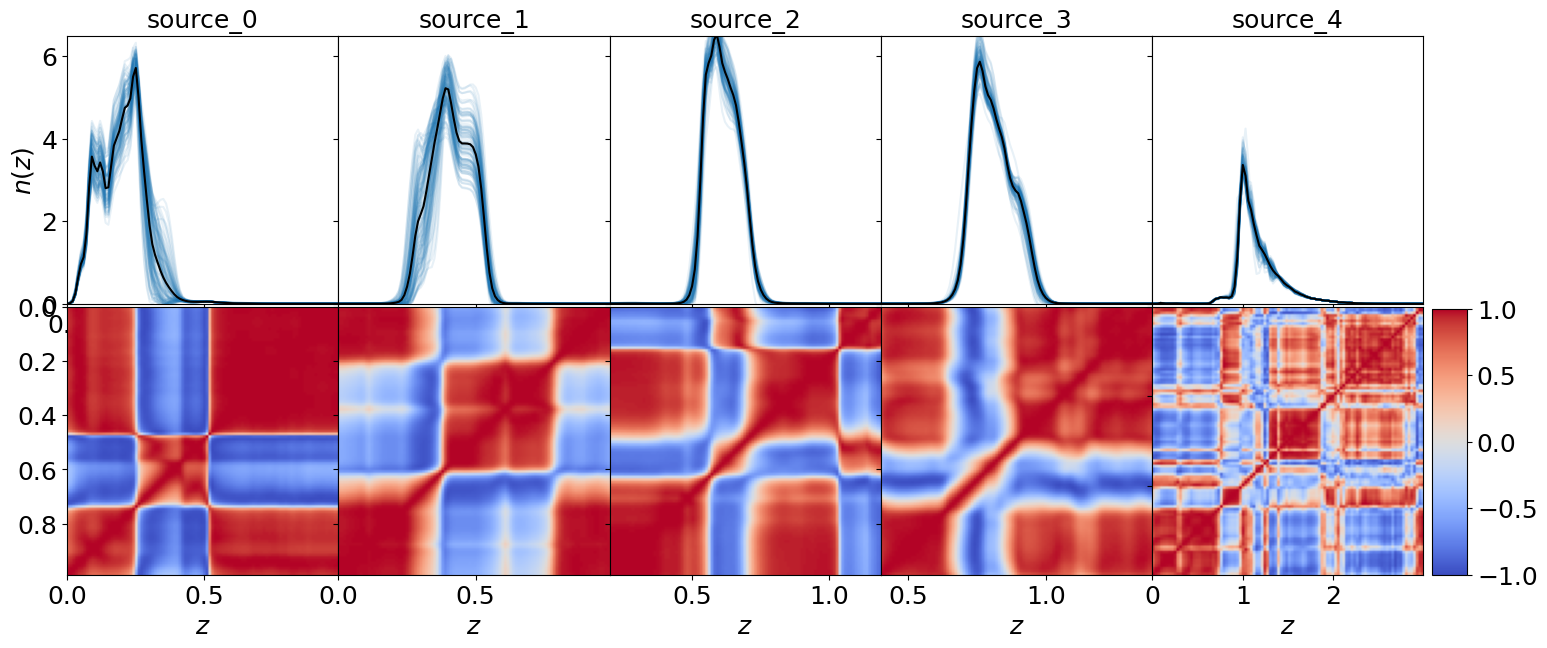

In [57]:
plot_tracers = ['source_0', 'source_1', 'source_2', 'source_3', 'source_4']
make_nzs_plots(pca_ss_qp.tracers, plot_tracers)

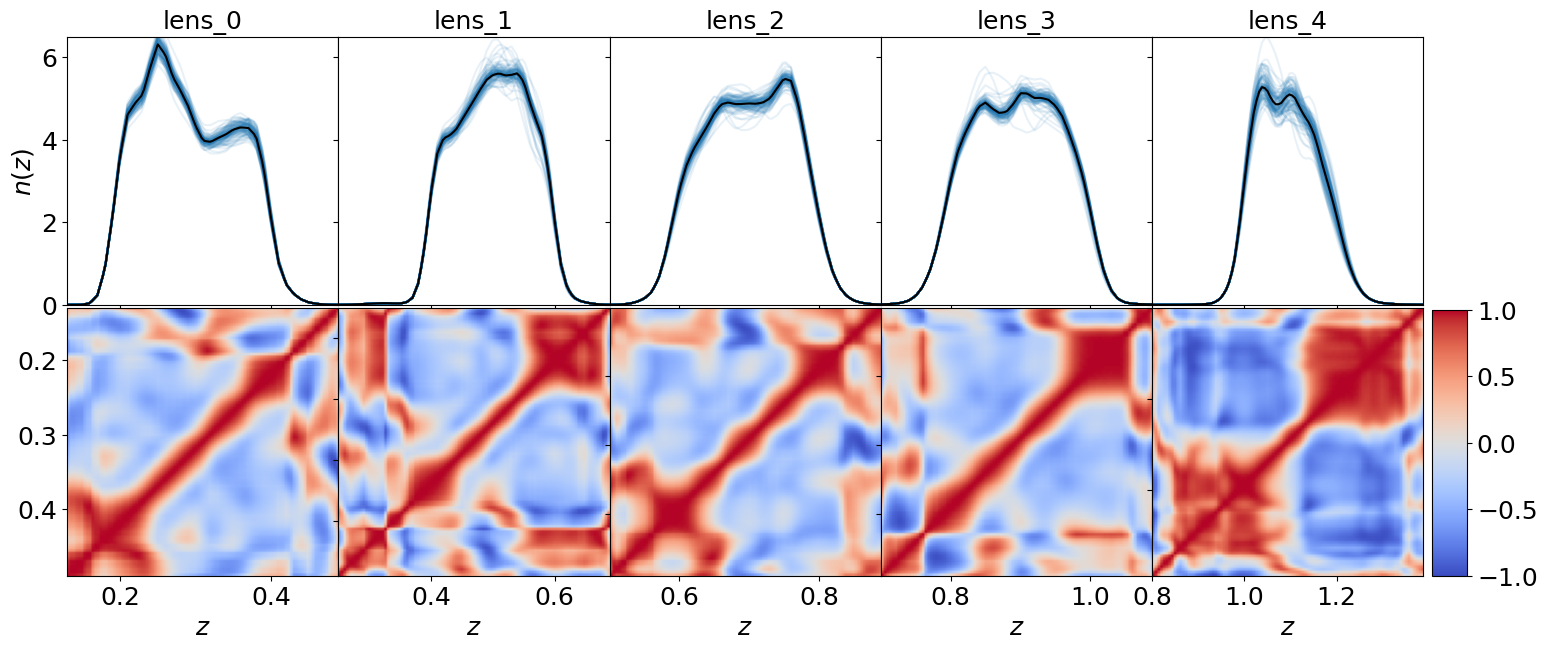

In [58]:
plot_tracers = ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4']
make_nzs_plots(pca_ss_qp.tracers, plot_tracers)

# Comparison

In [59]:
def make_nzs_comp_plot(methods, tracer, sacc_file=None):
    n_tracers = len(methods)
    figure, axis = plt.subplots(2, n_tracers, figsize=(n_tracers*3.5,7))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, key in enumerate(methods):
        method = methods[key]
        tomo = method[tracer]
        if i !=0:
            nzs = tomo[1][:50].T
            zs = tomo[0]
        else:
            nzs = tomo.ensemble.objdata["pdfs"][:50].T
            zs = tomo.z
        nz_mean = np.mean(nzs, axis=1)
        axis[0,i].plot(zs, nz_mean, '-', color="k")
        if sacc_file is not None:
            spec = sacc_file.tracers[tracer]
            photo_dz = np.mean(np.diff(zs))
            spec_dz = np.mean(np.diff(spec.z))
            alpha = photo_dz/spec_dz
        axis[0,i].plot(zs, nzs, '-', color="C0", alpha=0.1)
        cov = np.cov(nzs)
        err = np.sqrt(np.diag(cov))
        corr = cov/np.outer(err, err)
        axis[0,i].set_xlim([min(zs), max(zs)])
        axis[0,i].set_ylim([-0.001, 6.5])
        axis[0,i].set_title(key, y=0.9)
        if i == 0:
            axis[0,i].set_ylabel(r'$n_{\rm source \, 0}(z)$')
        else:
            axis[0,i].set_yticklabels([])
            axis[1,i].set_yticklabels([])
        im = axis[1,i].imshow(corr, aspect='auto',
                            origin='lower', cmap='coolwarm',
                             vmin=-1, vmax=1,
                            extent=[min(zs), max(zs), max(zs), min(zs)])
        axis[1,i].set_xlabel(r'$z$')

    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    plt.show()
    return figure

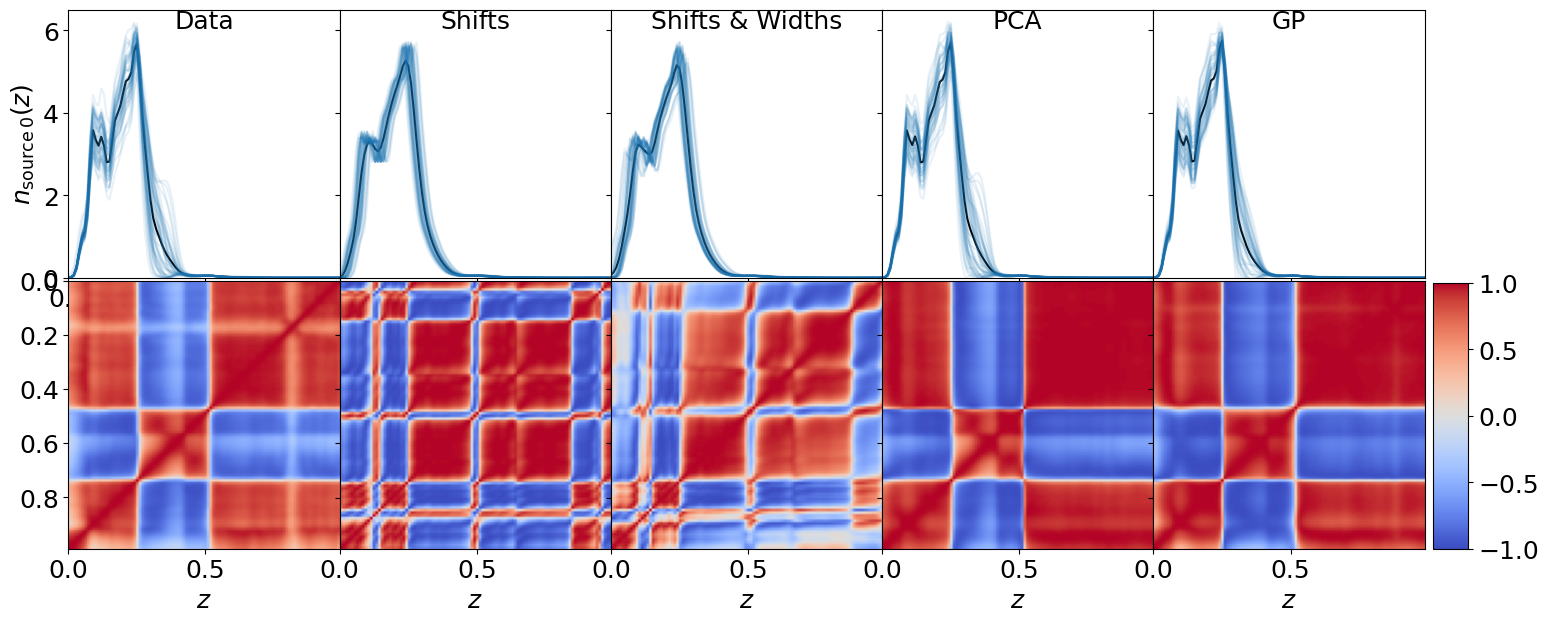

In [60]:
g = make_nzs_comp_plot({'Data': ss_qp.tracers, 'Shifts':shifted_nzs, 'Shifts & Widths':SnWs_nzs, 'PCA':pca_nzs, 'GP':gp_nzs}, 'source_0', sacc_file=ss_qp)
g.savefig("/home/jaimerzp/Documents/UCL/3x2_analytical/paper_plots/Y1_source_0_validation.pdf", bbox_inches='tight')

In [61]:
def comp_diag(methods, tracers, sacc_file=None):
    n_tracers = len(tracers)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*5,5))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    errs = {}
    covs = {}
    for key in methods.keys():
        errs[key] = 0
        covs[key] = 0
    for i, tracer in enumerate(tracers):
        nzs = sacc_file.tracers[tracer].ensemble.objdata["pdfs"].T
        ref_cov = np.cov(nzs)
        ref_err = np.sqrt(np.diag(ref_cov))
        for j, key in enumerate(methods):
            method = methods[key]
            tomo = method[tracer]
            nzs = tomo[1].T
            zs = tomo[0]
            cov = np.cov(nzs)
            err = np.sqrt(np.diag(cov))
            errs[key] += np.median(err/ref_err)
            covs[key] += np.mean(np.abs(np.abs(ref_cov)-np.abs(cov))/np.abs(ref_cov))
            axis[i].plot(zs, np.abs(err)/ref_err, '-', alpha=0.8)
        axis[i].plot(zs, np.ones_like(zs), 'k--', lw=1.5)
        axis[i].set_xlim([min(zs), max(zs)])
        axis[i].set_ylim([0.01, 20])
        axis[i].set_yscale('log')
        axis[i].set_title(tracer, y=0.9)
        if i == 0:
            axis[i].set_ylabel(r"$\sigma_{\rm nz}/\sigma_{\rm nz}^{\rm fid}$")
        else:
            axis[i].set_yticklabels([])
    plt.show()
    for key in errs.keys():
        print(key, errs[key]/len(tracers))
    return figure

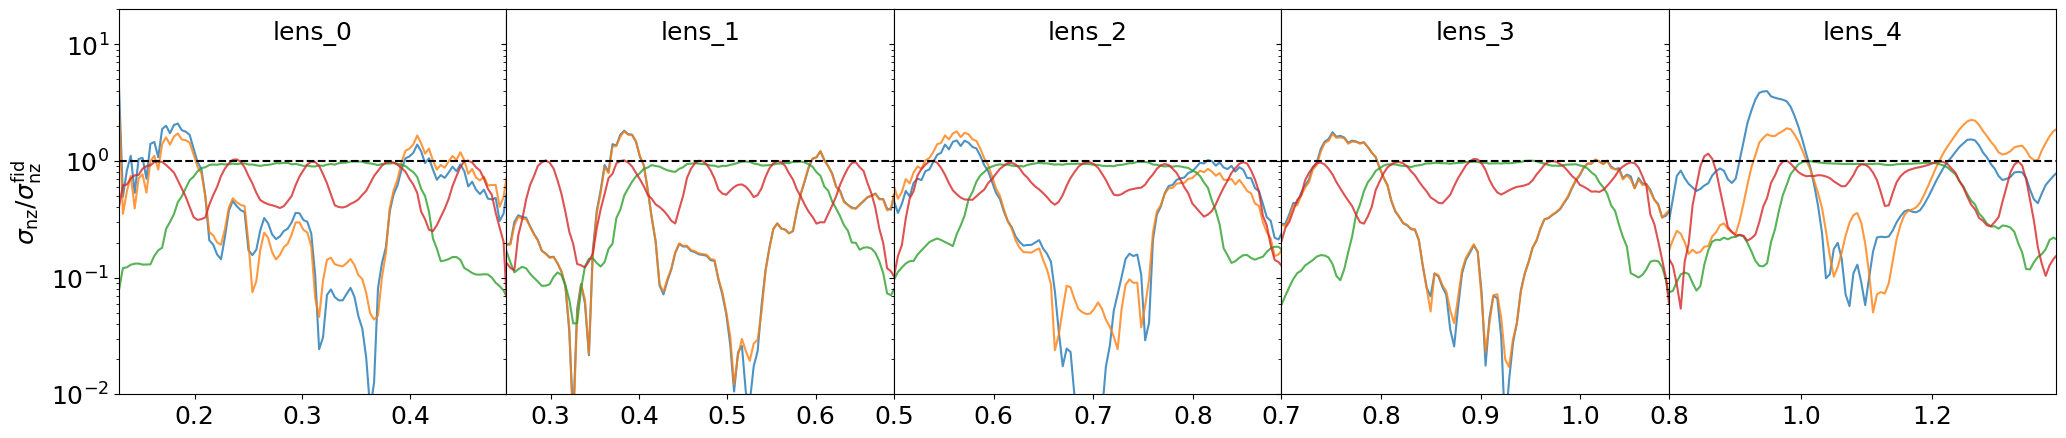

Shifts 0.46499155351080024
Shifts & Widths 0.4601250443565176
PCA 0.7340526223798003
GP 0.6205546938524089


In [62]:
g = comp_diag({
    'Shifts':shifted_nzs,
    'Shifts & Widths':SnWs_nzs,
    'PCA':pca_nzs, 
    'GP':gp_nzs},
    ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'],
    sacc_file=ss_qp)


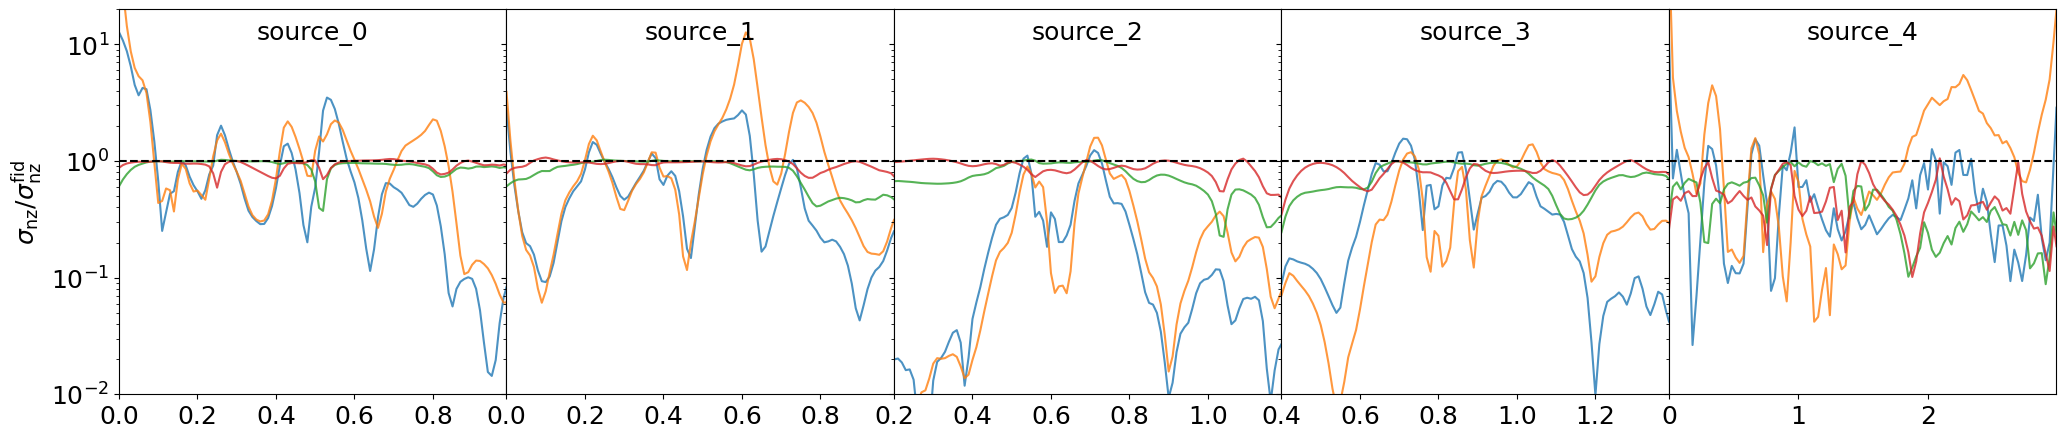

Shifts 0.3593225779380319
Shifts & Widths 0.578313296903614
PCA 0.7391710470494443
GP 0.8175602796570839


In [63]:
g = comp_diag({
    'Shifts':shifted_nzs,
    'Shifts & Widths':SnWs_nzs,
    'PCA':pca_nzs, 
    'GP':gp_nzs},
    ['source_0','source_1', 'source_2', 'source_3', 'source_4'],
    sacc_file=ss_qp)


In [64]:
def logdet(A, eps=1e-12):
    # Symmetrize to avoid numerical issues
    A = (A + A.T) / 2.0
    
    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(A)
    
    # Clamp eigenvalues
    eigvals_clamped = np.clip(eigvals, eps, None)
    
    # Reconstruct positive definite matrix
    A_pd = eigvecs @ np.diag(eigvals_clamped) @ eigvecs.T
    
    # Cholesky decomposition
    L = np.linalg.cholesky(A_pd)
    
    # Log determinant = 2 * sum(log(diag(L)))
    logdet = 2.0 * np.sum(np.log(np.diag(L)))
    
    return logdet

def varsum(A, eps=1e-12):
    # Symmetrize to avoid numerical issues
    A = (A + A.T) / 2.0
    
    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(A)
    
    # Clamp eigenvalues
    eigvals_clamped = np.clip(eigvals, eps, None)
    
    # Reconstruct positive definite matrix
    A_pd = eigvecs @ np.diag(eigvals_clamped) @ eigvecs.T
    
    varsum = np.sum(np.diag(A))
    
    return varsum

In [65]:
for key in ss_qp.tracers.keys():
    print(key,
          np.round(varsum(np.cov(ss_qp.tracers[key].ensemble.objdata()["pdfs"], rowvar=False)) / varsum(np.cov(shifted_nzs[key][1], rowvar=False)), 3),
          " & ",
          np.round(varsum(np.cov(ss_qp.tracers[key].ensemble.objdata()["pdfs"], rowvar=False)) / varsum(np.cov(SnWs_nzs[key][1], rowvar=False)), 3),
          " & ",
          np.round(varsum(np.cov(ss_qp.tracers[key].ensemble.objdata()["pdfs"], rowvar=False)) / varsum(np.cov(pca_nzs[key][1], rowvar=False)), 3),
          " & ",
          np.round(varsum(np.cov(ss_qp.tracers[key].ensemble.objdata()["pdfs"], rowvar=False)) / varsum(np.cov(gp_nzs[key][1], rowvar=False)), 3),
              r" \\\\"
          )
    print("\hline")

<>:12: SyntaxWarning: invalid escape sequence '\h'
<>:12: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_48397/1076864889.py:12: SyntaxWarning: invalid escape sequence '\h'
  print("\hline")
/tmp/ipykernel_48397/1076864889.py:12: SyntaxWarning: invalid escape sequence '\h'
  print("\hline")


TypeError: 'dict' object is not callable

In [ ]:
"""
n=3
source_0 2.009  &  2.089  &  1.306  &  12.172  \\\\
\hline
source_1 0.855  &  0.539  &  1.256  &  6.13  \\\\
\hline
source_2 1.309  &  0.701  &  1.159  &  7.063  \\\\
\hline
source_3 2.5  &  1.859  &  1.083  &  4.823  \\\\
\hline
source_4 2.435  &  2.076  &  1.338  &  5.8  \\\\
\hline
lens_0 7.887  &  4.455  &  1.362  &  3.678  \\\\
\hline
lens_1 2.835  &  1.989  &  1.134  &  197.972  \\\\
\hline
lens_2 6.253  &  3.714  &  1.415  &  9.494  \\\\
\hline
lens_3 3.391  &  2.38  &  1.114  &  77.516  \\\\
\hline
lens_4 4.233  &  3.437  &  1.3  &  28.196  \\\\
\hline

n = 5
source_0 2.009  &  2.089  &  1.105  &  4.61  \\\\
\hline
source_1 0.855  &  0.539  &  1.149  &  1.843  \\\\
\hline
source_2 1.309  &  0.701  &  1.056  &  6.051  \\\\
\hline
source_3 2.5  &  1.859  &  0.988  &  1.74  \\\\
\hline
source_4 2.435  &  2.076  &  1.143  &  2.433  \\\\
\hline
lens_0 7.887  &  4.455  &  1.075  &  3.038  \\\\
\hline
lens_1 2.835  &  1.989  &  1.019  &  2.214  \\\\
\hline
lens_2 6.253  &  3.714  &  1.141  &  2.545  \\\\
\hline
lens_3 3.391  &  2.38  &  1.052  &  1.864  \\\\
\hline
lens_4 4.233  &  3.437  &  1.076  &  2.549  \\\\
\hline

n=10
source_0 2.009  &  2.089  &  1.045  &  1.275  \\\\
\hline
source_1 0.855  &  0.539  &  1.029  &  1.251  \\\\
\hline
source_2 1.309  &  0.701  &  1.022  &  1.248  \\\\
\hline
source_3 2.5  &  1.859  &  1.03  &  1.348  \\\\
\hline
source_4 2.435  &  2.076  &  1.022  &  1.354  \\\\
\hline
lens_0 7.887  &  4.455  &  1.029  &  1.216  \\\\
\hline
lens_1 2.835  &  1.989  &  0.997  &  1.169  \\\\
\hline
lens_2 6.253  &  3.714  &  1.006  &  1.249  \\\\
\hline
lens_3 3.391  &  2.38  &  1.015  &  1.233  \\\\
\hline
lens_4 4.233  &  3.437  &  1.006  &  1.218  \\\\
\hline
"""

In [ ]:
figure, axis = plt.subplots(1, 2, figsize=(10,5))
figure.subplots_adjust(wspace=0, hspace=0.01)
axis[0].plot([1], [0.93], 'o', color='C0')
axis[0].plot([2], [2.06], 'o', color='C1')
axis[0].plot([3], [0.47], 'o', color='C2')
axis[0].plot([3], [0.68], 'o', color='C3')
axis[0].plot([5], [0.36], 'o', color='C2')
axis[0].plot([5], [0.39], 'o', color='C3')
axis[0].plot([10], [0.25], 'o', color='C2')
axis[0].plot([10], [0.10], 'o', color='C3')
axis[0].plot([20], [0.14], 'o', color='C2')
axis[0].plot([20], [0.01], 'o', color='C3')
axis[0].set_ylabel("Relative variance difference")
axis[0].set_xticks([1,2,3,5,10,20])
axis[0].set_ylim([-0.1, 1])
axis[0].set_title("Lenses")


axis[1].plot([1], [0.54], 'o', color='C0')
axis[1].plot([2], [0.61], 'o', color='C1')
axis[1].plot([3], [0.52], 'o', color='C2')
axis[1].plot([3], [0.63], 'o', color='C3')
axis[1].plot([5], [0.38], 'o', color='C2')
axis[1].plot([5], [0.40], 'o', color='C3')
axis[1].plot([10], [0.19], 'o', color='C2')
axis[1].plot([10], [0.10], 'o', color='C3')
axis[1].plot([20], [0.05], 'o', color='C2')
axis[1].plot([20], [0.01], 'o', color='C3')
axis[1].set_xticks([1,2,3,5,10,20])
axis[1].set_ylim([-0.05, 1])
axis[1].set_title("Sources")
axis[1].set_yticklabels([])
plt.show()

In [ ]:
def comp_eig(methods, tracers, sacc_file=None):
    n_tracers = len(tracers)
    figure, axis = plt.subplots(1, n_tracers, figsize=(n_tracers*3.5,5))
    figure.subplots_adjust(wspace=0, hspace=0.01)
    for i, tracer in enumerate(tracers):
        for j, key in enumerate(methods):
            method = methods[key]
            tomo = method[tracer]
            if j !=0:
                nzs = tomo[1].T
                zs = tomo[0]
            else:
                nzs = tomo.ensemble.objdata()["pdfs"].T
                zs = tomo.z
            cov = np.cov(nzs)
            eigvals, _ = np.linalg.eig(cov)
            axis[i].plot(eigvals, '-', alpha=0.8)
            axis[i].set_ylim([1e-12, 1e2])
            axis[i].set_yscale('log')
            axis[i].set_title(tracer, y=0.9)
    plt.show()
    return figure

In [ ]:
g = comp_eig({
    'Data': ss_qp.tracers,
    'Shifts':shifted_nzs,
    'Shifts & Widths':SnWs_nzs,
    'PCA':pca_nzs, 
    'GP':gp_nzs},
    ['lens_0', 'lens_1', 'lens_2', 'lens_3', 'lens_4'],)


In [ ]:
g = comp_eig({
    'Data': ss_qp.tracers,
    'Shifts':shifted_nzs,
    'Shifts & Widths':SnWs_nzs,
    'PCA':pca_nzs, 
    'GP':gp_nzs},
    ['source_0','source_1', 'source_2', 'source_3', 'source_4'])
